# MULTIVARIADO

In [298]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout, LSTM, TimeDistributed, Reshape, Conv2D, MaxPooling2D, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
import optuna
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanAbsoluteError
import random
from tensorflow.keras.layers import LeakyReLU


In [2]:
df = pd.read_csv("multivariate/Daily_Demand_Forecasting_Orders.csv", sep=';')
df.head(20)

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517
5,2,4,110.925,96.360,30.792,50.704,125.868,79.000,52042,8773,47522,24966,207.364
6,2,5,144.124,118.919,43.304,66.371,153.368,0.000,46573,33597,48269,20973,263.043
7,2,6,119.379,113.870,38.584,85.961,124.413,15.709,35033,26278,56665,18502,248.958
8,3,2,218.856,124.381,33.973,148.274,162.044,1.054,66612,19461,103376,10458,344.291
9,3,3,146.518,101.045,36.399,43.306,168.723,865.000,58224,7742,82395,11948,248.428


In [3]:
df.columns

Index(['Week of the month (first week, second, third, fourth or fifth week',
       'Day of the week (Monday to Friday)', 'Non-urgent order',
       'Urgent order', 'Order type A', 'Order type B', 'Order type C',
       'Fiscal sector orders', 'Orders from the traffic controller sector',
       'Banking orders (1)', 'Banking orders (2)', 'Banking orders (3)',
       'Target (Total orders)'],
      dtype='object')

In [4]:
df.dtypes

Week of the month (first week, second, third, fourth or fifth week      int64
Day of the week (Monday to Friday)                                      int64
Non-urgent order                                                      float64
Urgent order                                                          float64
Order type A                                                          float64
Order type B                                                          float64
Order type C                                                          float64
Fiscal sector orders                                                  float64
Orders from the traffic controller sector                               int64
Banking orders (1)                                                      int64
Banking orders (2)                                                      int64
Banking orders (3)                                                      int64
Target (Total orders)                                           

Todas las columnas ya estan en el tipo de dato que necesito. Ahora empezaré analizandolos.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 13 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Week of the month (first week, second, third, fourth or fifth week  60 non-null     int64  
 1   Day of the week (Monday to Friday)                                  60 non-null     int64  
 2   Non-urgent order                                                    60 non-null     float64
 3   Urgent order                                                        60 non-null     float64
 4   Order type A                                                        60 non-null     float64
 5   Order type B                                                        60 non-null     float64
 6   Order type C                                                        60 non-null     float64
 7   Fiscal sector order

In [6]:
len(df)

60

Como decia las instrucciones, en efecto son 60 filas.

In [7]:
df.describe()

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,3.016667,4.033333,172.554933,118.920850,52.112217,109.229850,139.531250,77.396133,44504.350000,46640.833333,79401.483333,23114.633333,300.873317
std,1.282102,1.401775,69.505788,27.170929,18.829911,50.741388,41.442932,186.502470,12197.905134,45220.736293,40504.420041,13148.039829,89.602041
min,1.000000,2.000000,43.651000,77.371000,21.826000,25.125000,74.372000,0.000000,11992.000000,3452.000000,16411.000000,7679.000000,129.412000
25%,2.000000,3.000000,125.348000,100.888000,39.456250,74.916250,113.632250,1.243250,34994.250000,20130.000000,50680.500000,12609.750000,238.195500
50%,3.000000,4.000000,151.062500,113.114500,47.166500,99.482000,127.990000,7.831500,44312.000000,32527.500000,67181.000000,18011.500000,288.034500
75%,4.000000,5.000000,194.606500,132.108250,58.463750,132.171000,160.107500,20.360750,52111.750000,45118.750000,94787.750000,31047.750000,334.237250
max,5.000000,6.000000,435.304000,223.270000,118.178000,267.342000,302.448000,865.000000,71772.000000,210508.000000,188411.000000,73839.000000,616.453000


In [8]:
print(df.isnull().sum())

Week of the month (first week, second, third, fourth or fifth week    0
Day of the week (Monday to Friday)                                    0
Non-urgent order                                                      0
Urgent order                                                          0
Order type A                                                          0
Order type B                                                          0
Order type C                                                          0
Fiscal sector orders                                                  0
Orders from the traffic controller sector                             0
Banking orders (1)                                                    0
Banking orders (2)                                                    0
Banking orders (3)                                                    0
Target (Total orders)                                                 0
dtype: int64


In [9]:
# Separar características (X) y objetivo (y)
X = df.drop(columns=['Target (Total orders)'])  
y = df['Target (Total orders)'] 

Tampoco hay datos nulos, asi que puedo continuar.

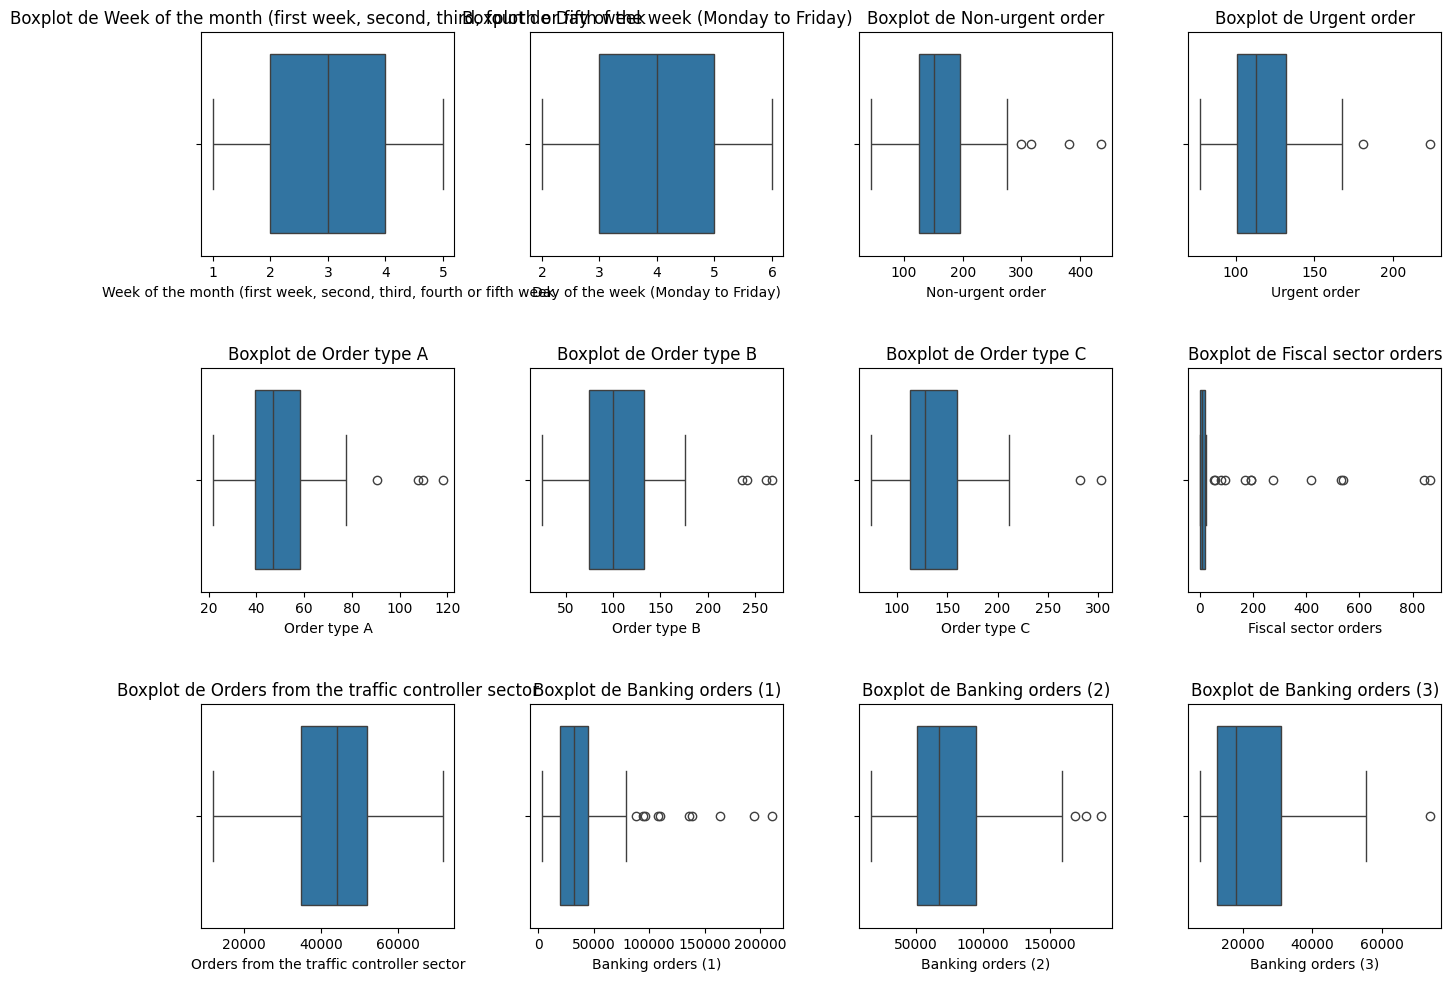

In [10]:
plt.figure(figsize=(16, 16)) 

rows = len(X.columns) // 4 + 1  # 4 pot fila
cols = 4 

for i, column in enumerate(X.columns):
    plt.subplot(rows, cols, i + 1)  
    sns.boxplot(data=X, x=column)
    plt.title(f"Boxplot de {column}")  # Título del gráfico

# Ajustar el espaciado entre los gráficos
plt.subplots_adjust(hspace=0.5, wspace=0.3)

plt.show()

1. Week of the month y Day of the week: Ambas variables muestran distribuciones relativamente uniformes. Al ser variables categóricas ordinales, probablemente no necesiten transformación

2. Non-urgent order y Urgent order: Ambas muestran algunas distribuciones asimétricas con outliers (puntos aislados a la derecha). Podrías beneficiarte de una *transformación logarítmica*. 

3. Order type A, B y C: Todas muestran asimetría positiva con outliers. Una *transformación logarítmica* (np.log1p) sería apropiada.

4. Fiscal sector orders: Esta variable muestra una distribución muy comprimida con muchos outliers dispersos. Claramente se beneficiaría de una transformación logarítmica.

5. Orders from traffic controller sector: Distribución relativamente simétrica pero con amplio rango. Una normalización es suficiente.

6. Banking orders (1, 2, 3): Todas muestran asimetrías y outliers. Transformación logarítmica recomendada.

In [11]:
df.columns

Index(['Week of the month (first week, second, third, fourth or fifth week',
       'Day of the week (Monday to Friday)', 'Non-urgent order',
       'Urgent order', 'Order type A', 'Order type B', 'Order type C',
       'Fiscal sector orders', 'Orders from the traffic controller sector',
       'Banking orders (1)', 'Banking orders (2)', 'Banking orders (3)',
       'Target (Total orders)'],
      dtype='object')

In [12]:
# Lista de las columnas a transformar
columns_to_transform = [
    'Non-urgent order', 'Urgent order', 'Order type A', 'Order type B', 
    'Order type C', 'Fiscal sector orders', 
    'Orders from the traffic controller sector', 
    'Banking orders (1)', 'Banking orders (2)', 'Banking orders (3)'
]


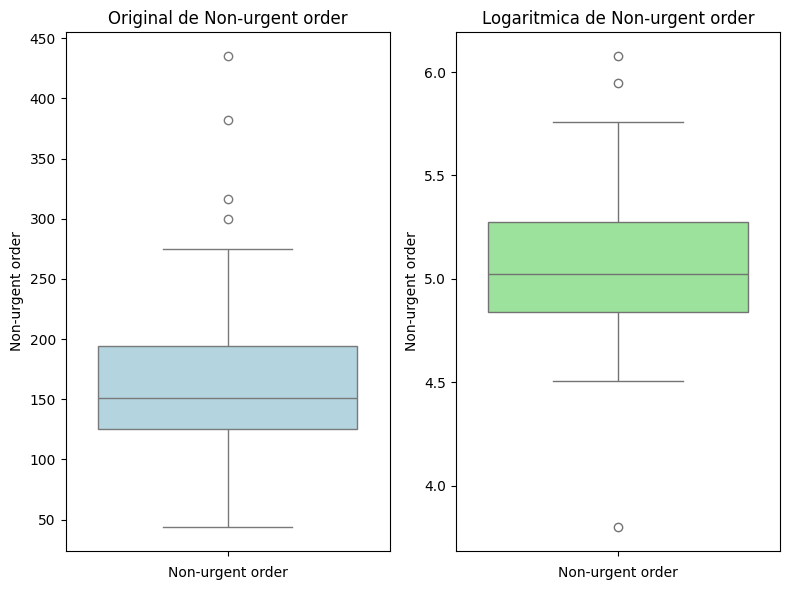

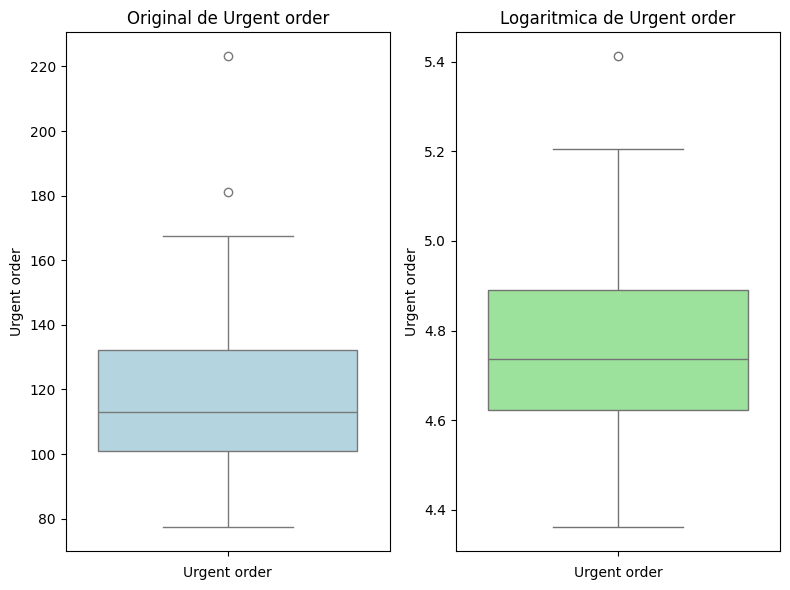

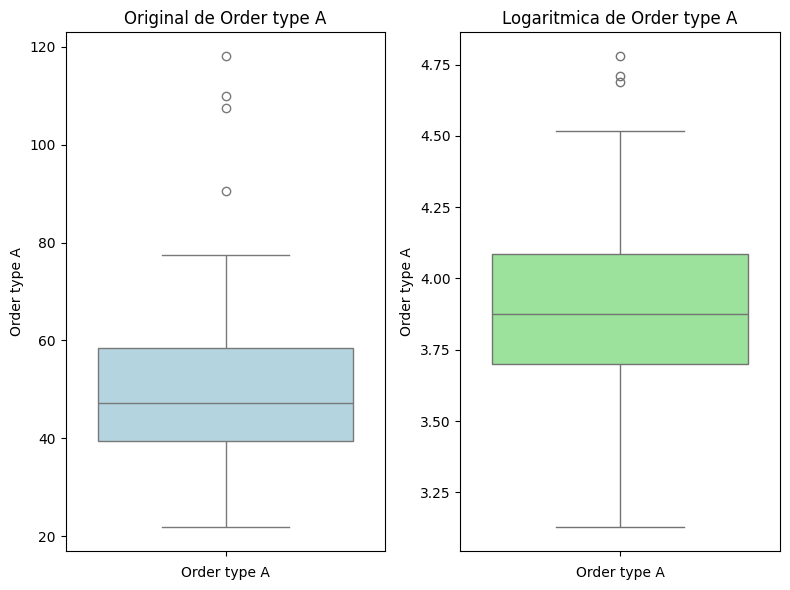

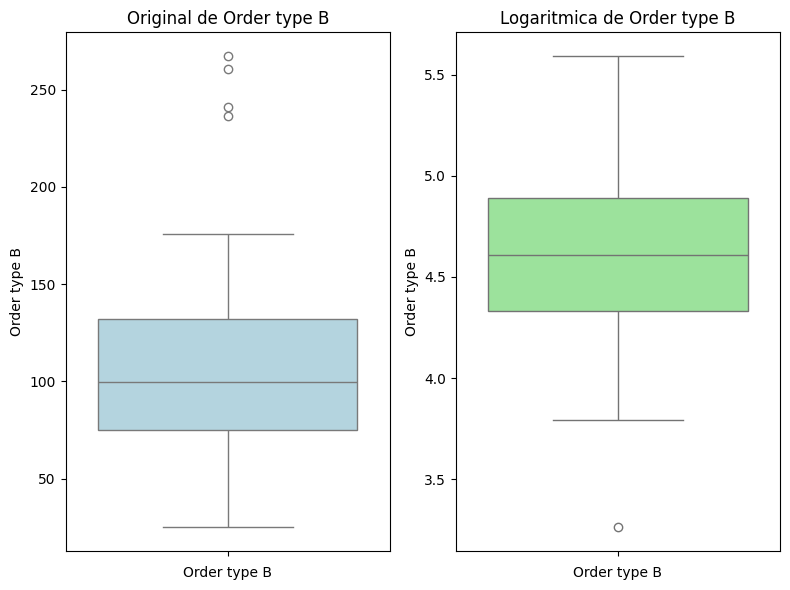

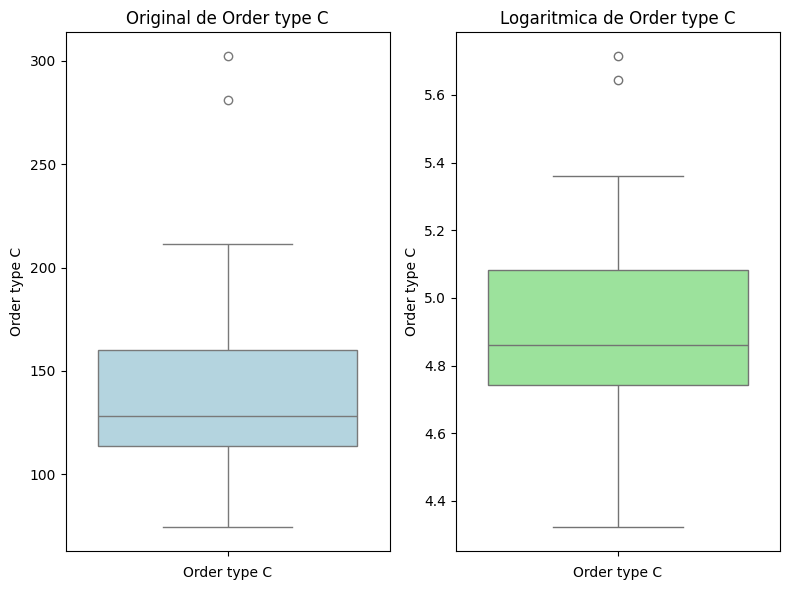

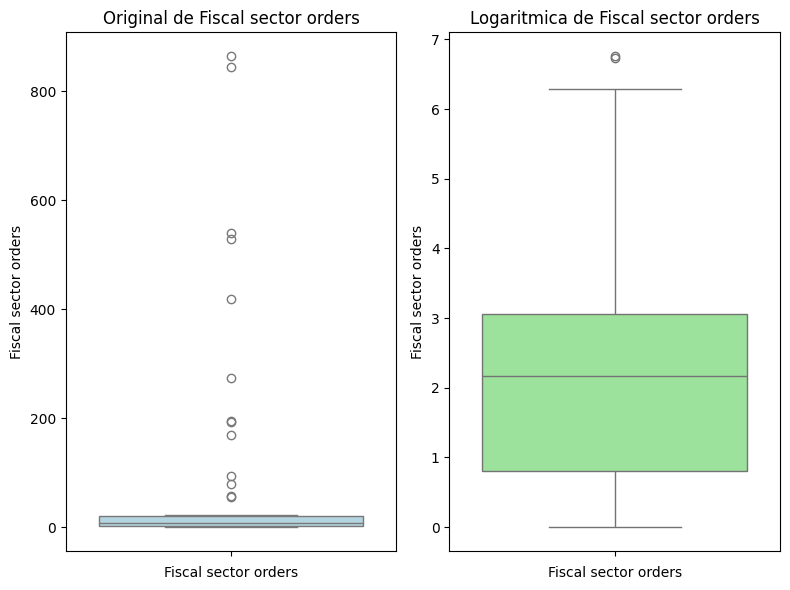

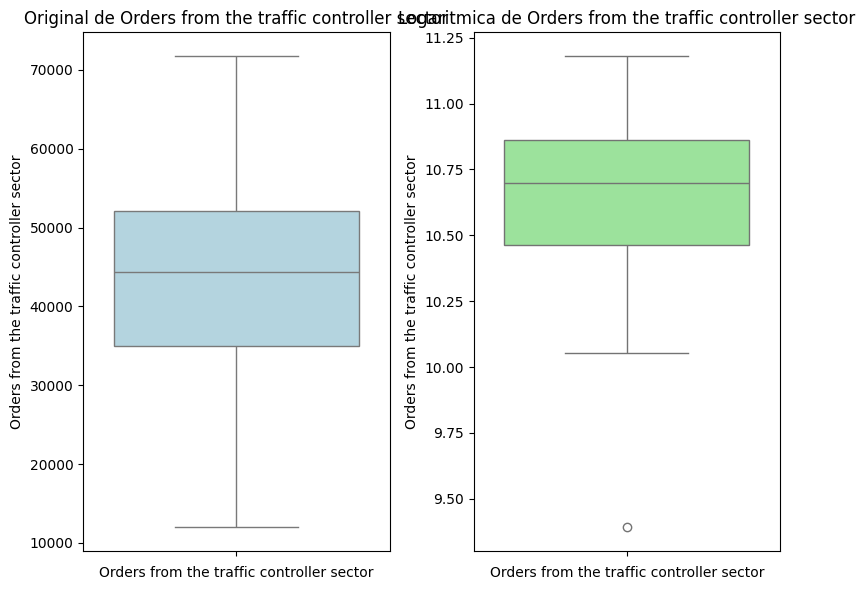

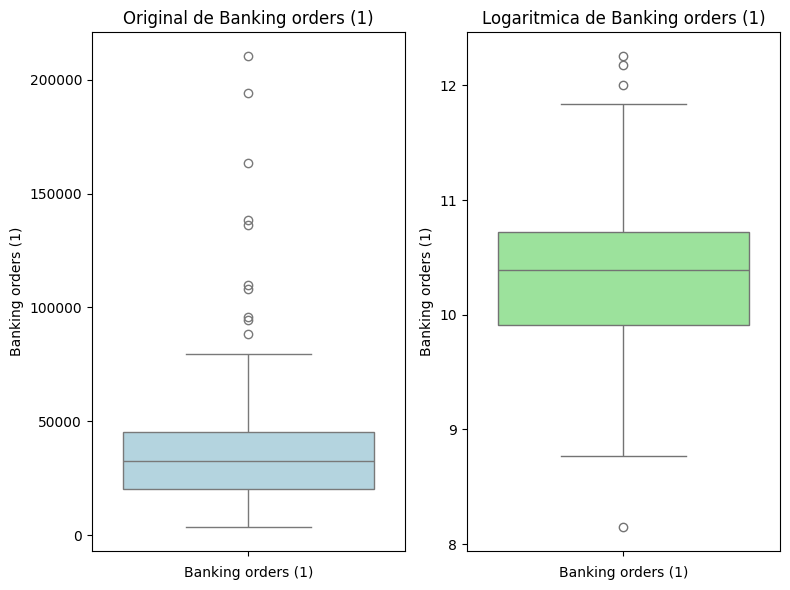

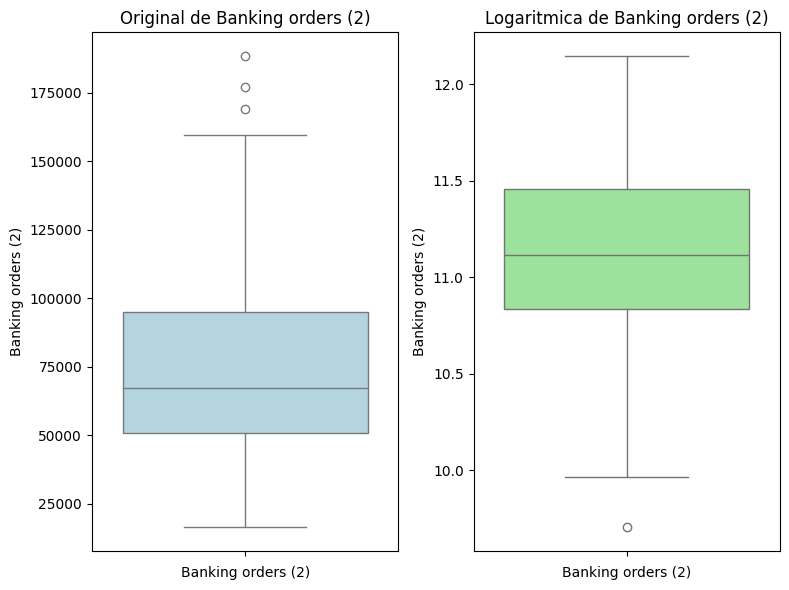

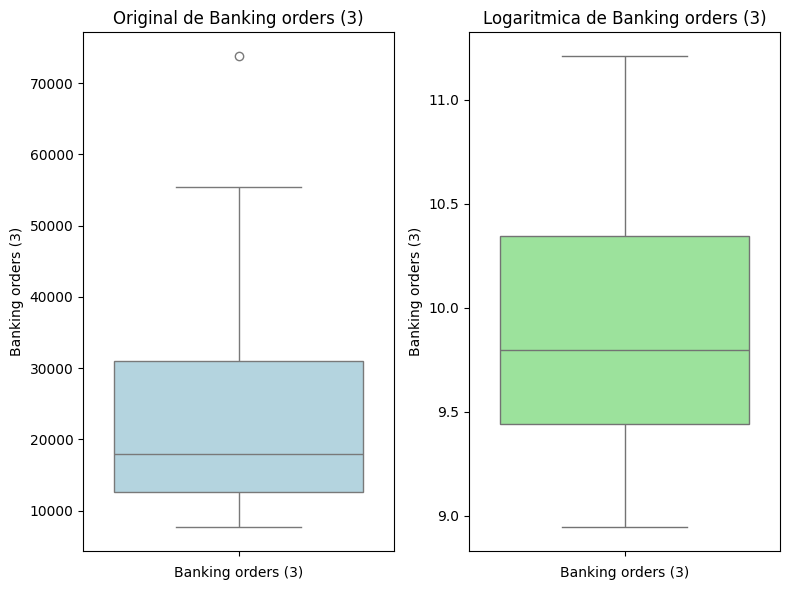

In [ ]:
# copia de los datos originales para comparar con las transformaciones
original_data = df[columns_to_transform].copy()

# transformación logarítmica
for col in columns_to_transform:
    df[col] = np.log1p(df[col])

# comparación
for col in columns_to_transform:
    plt.figure(figsize=(8, 6))
    # Boxplot originales
    plt.subplot(1, 2, 1)
    sns.boxplot(data=original_data[col], color='lightblue')
    plt.title(f"Original de {col}")
    plt.xlabel(col)
    # Boxplot log-transformados
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df[col], color='lightgreen')
    plt.title(f"Logaritmica de {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

Estas transformaciones han logrado:

- Comprimir el rango de valores, especialmente en el extremo superior
- Reducir la influencia de los valores extremos
- Hacer que las distribuciones sean más cercanas a la normal

In [15]:
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df)

In [16]:
df.describe()

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,0.504167,0.508333,0.564882,0.382921,0.479950,0.576639,0.421078,0.347584,0.709342,0.546678,0.592996,0.424516,0.352047
std,0.320525,0.350444,0.165062,0.200704,0.189154,0.191769,0.190508,0.293013,0.172278,0.205055,0.216542,0.233349,0.183972
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.250000,0.456300,0.249589,0.346279,0.457896,0.301041,0.119445,0.598534,0.428916,0.461991,0.219118,0.223356
50%,0.500000,0.500000,0.537589,0.357374,0.451836,0.578301,0.385772,0.320424,0.730324,0.545657,0.577465,0.376527,0.325686
75%,0.750000,0.750000,0.648053,0.503806,0.579327,0.699183,0.545395,0.452589,0.821091,0.625272,0.718232,0.617218,0.420550
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Ya estan todas mis variables entre 0 y 1. Y algunas fueron transformadas con su logaritmo.

In [17]:
len(df.columns)

13

#### Dividir los datos

In [18]:
# Entrenamiento 70
train = df.iloc[:int(len(df) * 0.7), :]

# Validación 15
val = df.iloc[int(len(df) * 0.7):int(len(df) * 0.85), :]

# Prueba 15
test = df.iloc[int(len(df) * 0.85):, :]


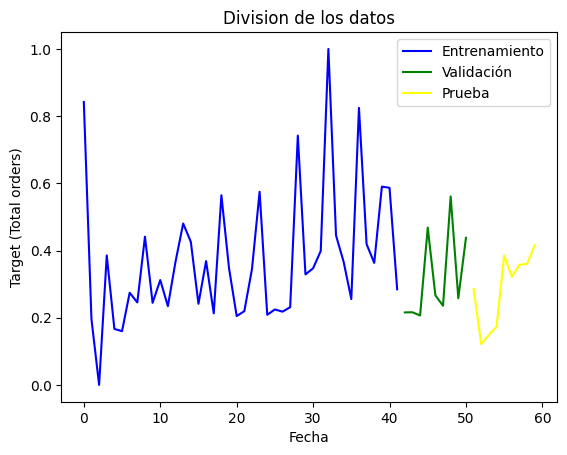

In [ ]:

y = "Target (Total orders)" # Variable a predecir


plt.plot(train.index, train[y], color="blue", label="Entrenamiento")
plt.plot(val.index, val[y], color="green", label="Validación")
plt.plot(test.index, test[y], color="yellow", label="Prueba")

plt.xlabel("Fecha")
plt.ylabel(y)
plt.legend()
plt.title(f"Division de los datos")
plt.show()

In [20]:
# Para que no esten cambiando mis resultados
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)

In [21]:
n_steps_in = 6
n_steps_out = 1

In [22]:
# Split the multivariate data in steps
def split_multivariate_sequence_m_step(sequence: np.ndarray, n_steps_in: int, n_steps_out: int=1):
    """
    Divide una secuencia multivariada en muestras
    :param sequence: Array de numpy con la secuencia
    :param n_steps_in: Número de pasos de entrada
    :param n_steps_out: Número de pasos de salida
    :return: Devuelve dos arrays de numpy con las muestras de entrada y salida
    """
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1

        # comprobar si estamos más allá de la secuencia
        if out_end_ix > len(sequence):
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix - 1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [23]:
X_train, y_train = split_multivariate_sequence_m_step(train.values, n_steps_in, n_steps_out)

In [24]:
#split the data and show shapes
n_steps_in, n_steps_out = 6, 1

X_train, y_train = split_multivariate_sequence_m_step(train.values, n_steps_in, n_steps_out)
X_val, y_val = split_multivariate_sequence_m_step(val.values, n_steps_in, n_steps_out)
X_test, y_test = split_multivariate_sequence_m_step(test.values, n_steps_in, n_steps_out)

print('Train split shape', X_train.shape, y_train.shape)
print('Val split shape', X_val.shape, y_val.shape)
print('Test split shape', X_test.shape, y_test.shape)

Train split shape (37, 6, 12) (37, 1)
Val split shape (4, 6, 12) (4, 1)
Test split shape (4, 6, 12) (4, 1)


In [25]:
n_steps = X_train.shape[1] 
n_features = X_train.shape[2]

### CNN 1

In [330]:
cnn_model_1 = Sequential([
    Conv1D(32, 2, activation='relu', padding='same', input_shape=(n_steps, n_features)),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
], name='CNN_Model_1')

/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
cnn_model_1.compile(optimizer='adam', loss='mse', metrics=[MeanAbsoluteError()])


In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

In [29]:
history = cnn_model_1.fit(
    X_train, y_train,
    epochs=200,  
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0839 - mean_absolute_error: 0.2277 - val_loss: 0.0135 - val_mean_absolute_error: 0.1068
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0367 - mean_absolute_error: 0.1366 - val_loss: 0.0145 - val_mean_absolute_error: 0.0998
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0296 - mean_absolute_error: 0.1416 - val_loss: 0.0226 - val_mean_absolute_error: 0.1289
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0322 - mean_absolute_error: 0.1546 - val_loss: 0.0236 - val_mean_absolute_error: 0.1350
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0275 - mean_absolute_error: 0.1426 - val_loss: 0.0196 - val_mean_absolute_error: 0.1273
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0213 - mean_absolute_error: 0.1234 - val_loss: 0.0146 - val_mean_absolute_error: 0.1122
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0155 - mean_absolute_error: 0.0997 - val_loss: 0.010

In [30]:
# Evaluación
test_loss, test_mae = cnn_model_1.evaluate(X_test, y_test, verbose=0)

#test (normalizado)
y_pred_normalized = cnn_model_1.predict(X_test)

# Invertir la normalización tanto para las predicciones como para los valores reales
y_pred = scaler.inverse_transform(np.hstack([np.zeros((y_pred_normalized.shape[0], df.shape[1]-1)), y_pred_normalized]))[:, -1]
y_test_original = scaler.inverse_transform(np.hstack([np.zeros((y_test.shape[0], df.shape[1]-1)), y_test.reshape(-1, 1)]))[:, -1]

# Calcular métricas en la escala original
test_mae_original = mean_absolute_error(y_test_original, y_pred)
test_rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred))

print(f'Test MAE (escala normalizada): {test_mae}')
print(f'Test MAE (escala original): {test_mae_original}')
print(f'Test RMSE (escala original): {test_rmse_original}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test MAE (escala normalizada): 0.024588800966739655
Test MAE (escala original): 11.97575311434268
Test RMSE (escala original): 14.924983574005273


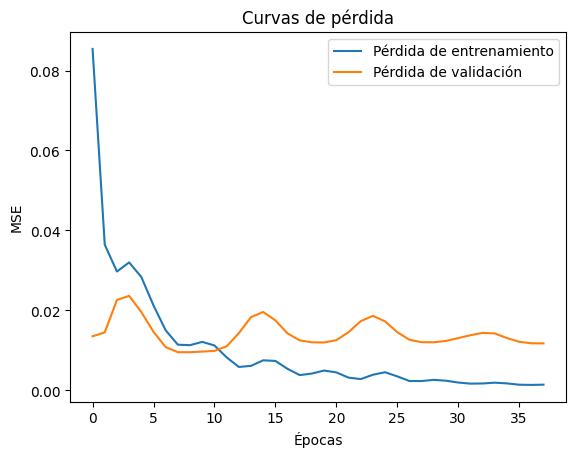

In [31]:
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.title("Curvas de pérdida")
plt.legend()
plt.show()


In [32]:
#desescalar
y_pred = scaler.inverse_transform(np.hstack([np.zeros((y_pred_normalized.shape[0], df.shape[1]-1)), y_pred_normalized]))[:, -1]
y_test_original = scaler.inverse_transform(np.hstack([np.zeros((y_test.shape[0], df.shape[1]-1)), y_test.reshape(-1, 1)]))[:, -1]


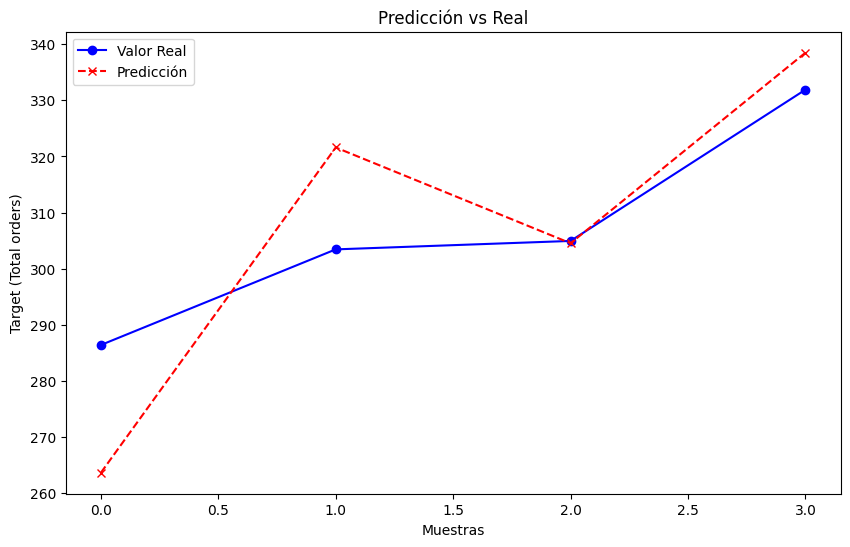

In [33]:
# predicciones vs reales
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Valor Real', color='blue', linestyle='-', marker='o')
plt.plot(y_pred, label='Predicción', color='red', linestyle='--', marker='x')
plt.title('Predicción vs Real')
plt.xlabel('Muestras')
plt.ylabel('Target (Total orders)')
plt.legend()
plt.show()


Para esta primera arquitectura puse un conv1D, de 32 filtros con un kernel de 2, para detectar patrones como subidas o bajadas de valores. Use una función relu, para no linealidad y para aprender patrones complejos.
Luego reducí la dimensionalidad con un max pooling a la mitad, esto para prevenir sobreajuste y extraer las caracteristicas importantes. Luego aplane para poder usar dense y aprender patrones más complejos. 


Este modelo obtuvo resultados satisfactorios, aunque no los mejores. Tiene un MAE y RMSE relativamente bajos. El podelo no predice con exatitud, pero si se acreca un poco a los valores reales.

### CNN2

In [34]:
cnn_model_2 = Sequential([
    Conv1D(64, 3, activation='relu', padding='same', input_shape=(n_steps, n_features)),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu', padding='same'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1)
])


/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
cnn_model_2.compile(optimizer='adam', loss='mse', metrics=[MeanAbsoluteError()])


In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

In [37]:
history = cnn_model_1.fit(
    X_train, y_train,
    epochs=200,  
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0117 - mean_absolute_error: 0.0743 - val_loss: 0.0098 - val_mean_absolute_error: 0.0835
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0106 - mean_absolute_error: 0.0700 - val_loss: 0.0104 - val_mean_absolute_error: 0.0906
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0095 - mean_absolute_error: 0.0681 - val_loss: 0.0116 - val_mean_absolute_error: 0.0999
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0085 - mean_absolute_error: 0.0661 - val_loss: 0.0130 - val_mean_absolute_error: 0.1069
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0080 - mean_absolute_error: 0.0650 - val_loss: 0.0139 - val_mean_absolute_error: 0.1106
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0074 - mean_absolute_error: 0.0643 - val_loss: 0.0137 - val_mean_absolute_error: 0.1091
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0062 - mean_absolute_error: 0.0584 - val_loss: 0.012

In [38]:
# Evaluación
test_loss, test_mae = cnn_model_1.evaluate(X_test, y_test, verbose=0)

#test (normalizado)
y_pred_normalized = cnn_model_1.predict(X_test)

# Invertir la normalización tanto para las predicciones como para los valores reales
y_pred = scaler.inverse_transform(np.hstack([np.zeros((y_pred_normalized.shape[0], df.shape[1]-1)), y_pred_normalized]))[:, -1]
y_test_original = scaler.inverse_transform(np.hstack([np.zeros((y_test.shape[0], df.shape[1]-1)), y_test.reshape(-1, 1)]))[:, -1]

# Calcular métricas en la escala original
test_mae_original = mean_absolute_error(y_test_original, y_pred)
test_rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred))

print(f'Test MAE (escala normalizada): {test_mae}')
print(f'Test MAE (escala original): {test_mae_original}')
print(f'Test RMSE (escala original): {test_rmse_original}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test MAE (escala normalizada): 0.026648379862308502
Test MAE (escala original): 12.978855148047202
Test RMSE (escala original): 15.022723028580936


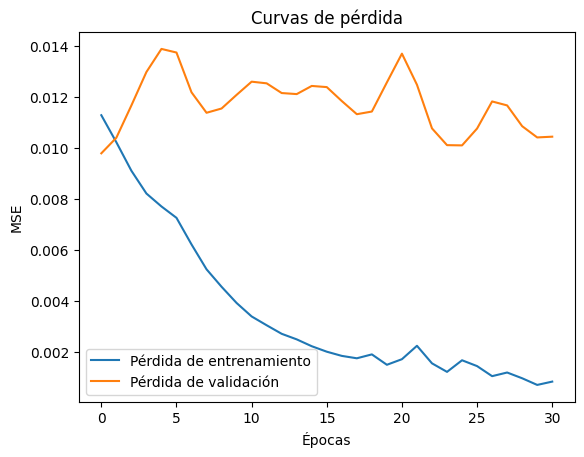

In [39]:
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.title("Curvas de pérdida")
plt.legend()
plt.show()


In [40]:
#desescalar
y_pred = scaler.inverse_transform(np.hstack([np.zeros((y_pred_normalized.shape[0], df.shape[1]-1)), y_pred_normalized]))[:, -1]
y_test_original = scaler.inverse_transform(np.hstack([np.zeros((y_test.shape[0], df.shape[1]-1)), y_test.reshape(-1, 1)]))[:, -1]


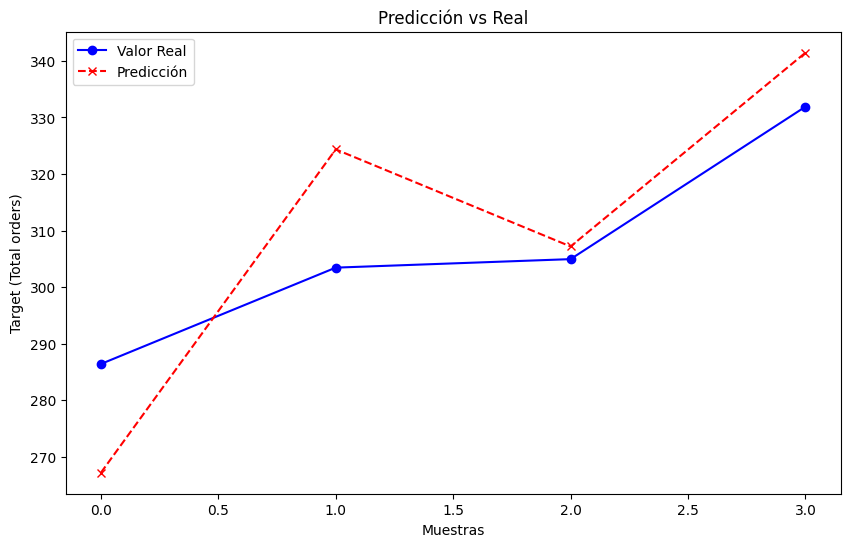

In [41]:
# predicciones vs reales
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Valor Real', color='blue', linestyle='-', marker='o')
plt.plot(y_pred, label='Predicción', color='red', linestyle='--', marker='x')
plt.title('Predicción vs Real')
plt.xlabel('Muestras')
plt.ylabel('Target (Total orders)')
plt.legend()
plt.show()


Para esta segunda arquitectura usé una estructura más profunda. Inicié con una capa Conv1D de 64 filtros y un kernel de tamaño 3, con activación ReLU y padding 'same', para detectar patrones un poco más largos que en el primer modelo. Luego apliqué un MaxPooling1D para reducir la dimensionalidad y conservar las características más relevantes.

Después agregué una segunda capa Conv1D con 128 filtros, también con kernel de tamaño 3 y la misma activación. Esta segunda convolución permite capturar características más abstractas. Nuevamente usé MaxPooling1D para seguir reduciendo la complejidad.

Posteriormente aplané los datos con Flatten para poder conectarlos con las capas densas. Añadí una capa Dense de 128 unidades con activación ReLU para aprender patrones complejos, y finalmente una capa de salida con una sola neurona, adecuada para regresión.

Este modelo obtuvo resultados muy similares al primer CNN. El MAE y el RMSE aumentaron ligeramente, pero la diferencia no es significativa. La arquitectura más profunda no necesariamente mejoró la predicción, aunque mantuvo un desempeño aceptable. El modelo no predice con exactitud, pero sigue acercándose de forma razonable a los valores reales.

### CNN3

In [ ]:
cnn_deep_model = Sequential([
    # Primera capa convolucional
    Conv1D(64, 3, activation='relu', padding='same', input_shape=(n_steps, n_features)),
    MaxPooling1D(2),
    
    # Segunda capa convolucional
    Conv1D(128, 3, activation='relu', padding='same'),
    MaxPooling1D(2),
    
    # Tercera capa convolucional
    Conv1D(256, 3, activation='relu', padding='same'),
    MaxPooling1D(2),
    
    # Cuarta capa convolucional
    Conv1D(512, 3, activation='relu', padding='same'),
    MaxPooling1D(2),
    
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    
    # Capa de salida
    Dense(1)
])

cnn_deep_model.compile(optimizer='adam', loss='mse', metrics=[MeanAbsoluteError()])


cnn_deep_model.summary()


/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 6, 64)          │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 3, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 1, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 0, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 0, 512)         │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 0, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 0)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 520,385 (1.99 MB)

 Trainable params: 520,385 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

In [46]:
history = cnn_model_1.fit(
    X_train, y_train,
    epochs=200,  
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0106 - mean_absolute_error: 0.0702 - val_loss: 0.0104 - val_mean_absolute_error: 0.0899
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0090 - mean_absolute_error: 0.0654 - val_loss: 0.0116 - val_mean_absolute_error: 0.0989
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0078 - mean_absolute_error: 0.0621 - val_loss: 0.0127 - val_mean_absolute_error: 0.1054
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0076 - mean_absolute_error: 0.0629 - val_loss: 0.0128 - val_mean_absolute_error: 0.1058
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0064 - mean_absolute_error: 0.0576 - val_loss: 0.0113 - val_mean_absolute_error: 0.0973
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0054 - mean_absolute_error: 0.0517 - val_loss: 0.0102 - val_mean_absolute_error: 0.0881
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0041 - mean_absolute_error: 0.0453 - val_loss: 0.010

In [47]:
# Evaluación
test_loss, test_mae = cnn_model_1.evaluate(X_test, y_test, verbose=0)

#test (normalizado)
y_pred_normalized = cnn_model_1.predict(X_test)

# Invertir la normalización 
y_pred = scaler.inverse_transform(np.hstack([np.zeros((y_pred_normalized.shape[0], df.shape[1]-1)), y_pred_normalized]))[:, -1]
y_test_original = scaler.inverse_transform(np.hstack([np.zeros((y_test.shape[0], df.shape[1]-1)), y_test.reshape(-1, 1)]))[:, -1]

# Calcular métricas en la escala original
test_mae_original = mean_absolute_error(y_test_original, y_pred)
test_rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred))

print(f'Test MAE (escala normalizada): {test_mae}')
print(f'Test MAE (escala original): {test_mae_original}')
print(f'Test RMSE (escala original): {test_rmse_original}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test MAE (escala normalizada): 0.01946994662284851
Test MAE (escala original): 9.48266434701533
Test RMSE (escala original): 14.46787424776711


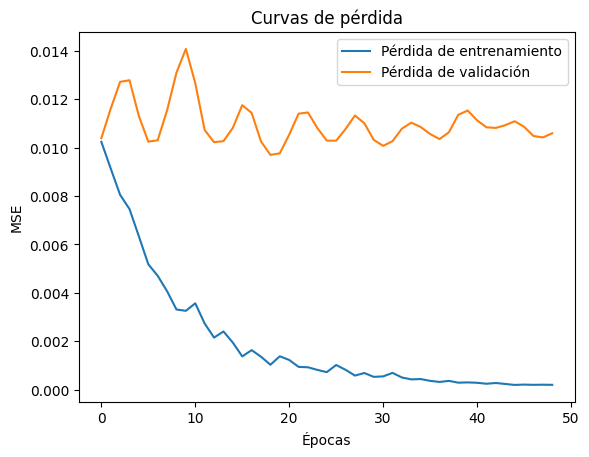

In [48]:
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.title("Curvas de pérdida")
plt.legend()
plt.show()


In [49]:
#desescalar
y_pred = scaler.inverse_transform(np.hstack([np.zeros((y_pred_normalized.shape[0], df.shape[1]-1)), y_pred_normalized]))[:, -1]
y_test_original = scaler.inverse_transform(np.hstack([np.zeros((y_test.shape[0], df.shape[1]-1)), y_test.reshape(-1, 1)]))[:, -1]


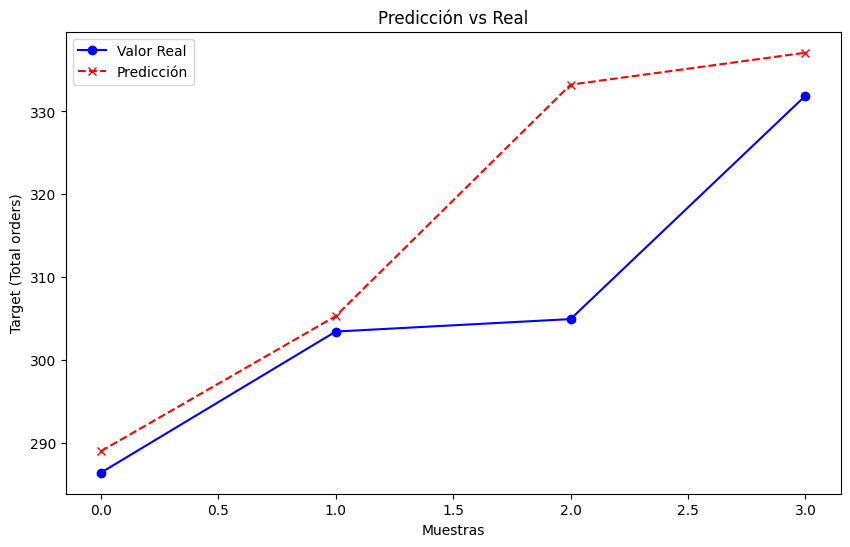

In [50]:
# predicciones vs reales
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Valor Real', color='blue', linestyle='-', marker='o')
plt.plot(y_pred, label='Predicción', color='red', linestyle='--', marker='x')
plt.title('Predicción vs Real')
plt.xlabel('Muestras')
plt.ylabel('Target (Total orders)')
plt.legend()
plt.show()


Para esta arquitectura profunda tipo CNN, incrementé progresivamente la complejidad con varias capas convolucionales. Inicié con una capa Conv1D de 64 filtros y kernel de tamaño 3 con activación ReLU para captar patrones iniciales en los datos. Le sigue un MaxPooling1D para reducir la dimensionalidad.

Después, añadí tres capas adicionales de Conv1D, aumentando los filtros a 128, 256 y finalmente 512, todas con kernel de 3 y activación ReLU. Estas capas permiten detectar patrones más complejos y abstractos conforme avanzamos en profundidad. Cada una es seguida de un MaxPooling1D para controlar el tamaño de los datos y prevenir sobreajuste.

Luego, los datos se aplanan con Flatten para alimentar una capa densa de 512 neuronas, donde se realiza un aprendizaje más profundo y no lineal. Añadí Dropout de 0.4 para regularizar y reducir el riesgo de sobreajuste. Finalmente, una capa de salida Dense(1) genera el valor predicho, apropiado para regresión.

Este modelo obtuvo un desempeño ligeramente mejor comparado con modelos anteriores. El MAE  se redujo, lo cual indica una mejora en la precisión de las predicciones. El RMSE se mantuvo prácticamente igual, lo que sugiere que aunque el modelo comete errores más pequeños en promedio, todavía tiene algunas predicciones con mayor desviación. Aun así, el desempeño general es competitivo, y la arquitectura profunda ayudó a capturar relaciones más complejas en los datos.

### OPTUNA CNN

In [122]:
def objective(trial):
    # Hiperparámetros a buscar
    filters_1 = trial.suggest_categorical('filters_1', [32, 64, 128])
    filters_2 = trial.suggest_categorical('filters_2', [64, 128, 256])
    kernel_size = trial.suggest_int('kernel_size', 2,5)
    dense_units = trial.suggest_int('dense_units', 64, 256)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

    # Construir el modelo CNN basado en el primero
    model = Sequential([
        Conv1D(filters_1, kernel_size, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])),
        MaxPooling1D(2),
        Conv1D(filters_2, kernel_size, activation='relu', padding='same'),
        MaxPooling1D(2),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mae'])

 
    # Entrenar
    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=100,
              batch_size=32,
              verbose=0)

    #  MAE en validación
    val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
    return val_mae


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Mejores hiperparámetros encontrados:")
print(study.best_params)


[I 2025-04-06 12:15:51,811] A new study created in memory with name: no-name-c7d0c1d7-ccac-46df-b6d9-a04efc503422
/var/folders/vj/k67r6tzn6k3gd90ph1hz0kbr0000gn/T/ipykernel_4591/141026736.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-04-06 12:15:54,615] Trial 0 finished with value: 0.1020984947681427 and parameters: {'filters_1': 128, 'filters_2': 128, 'ker

Mejores hiperparámetros encontrados:
{'filters_1': 64, 'filters_2': 64, 'kernel_size': 4, 'dense_units': 237, 'learning_rate': 0.00970865537041587}


In [ ]:
#hacer el mejor modelo
best_params = study.best_params

# Crear el modelo basado en cnn1
model = Sequential([
    Conv1D(best_params['filters_1'], best_params['kernel_size'], activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(2),
    Conv1D(best_params['filters_2'], best_params['kernel_size'], activation='relu', padding='same'),
    MaxPooling1D(2),
    Flatten(),
    Dense(best_params['dense_units'], activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
              loss='mse',
              metrics=['mae'])


model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=100,
          batch_size=32,
          verbose=1)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.6186 - mae: 0.3470 - val_loss: 0.0275 - val_mae: 0.1507
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0864 - mae: 0.2636 - val_loss: 0.2313 - val_mae: 0.4630
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2420 - mae: 0.4576 - val_loss: 0.0223 - val_mae: 0.1096
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0436 - mae: 0.1423 - val_loss: 0.0276 - val_mae: 0.1465
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0410 - mae: 0.1782 - val_loss: 0.0443 - val_mae: 0.1653
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0482 - mae: 0.1528 - val_loss: 0.0441 - val_mae: 0.1664
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0533 - mae: 0.1576 - val_loss: 0.0148 - val_mae: 0.1156
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0272 - mae: 0.1257 - val_loss: 0.0235 - val_mae: 0.1317
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0367 - mae: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
MAE en test (original): 15.24
RMSE en test (original): 18.40


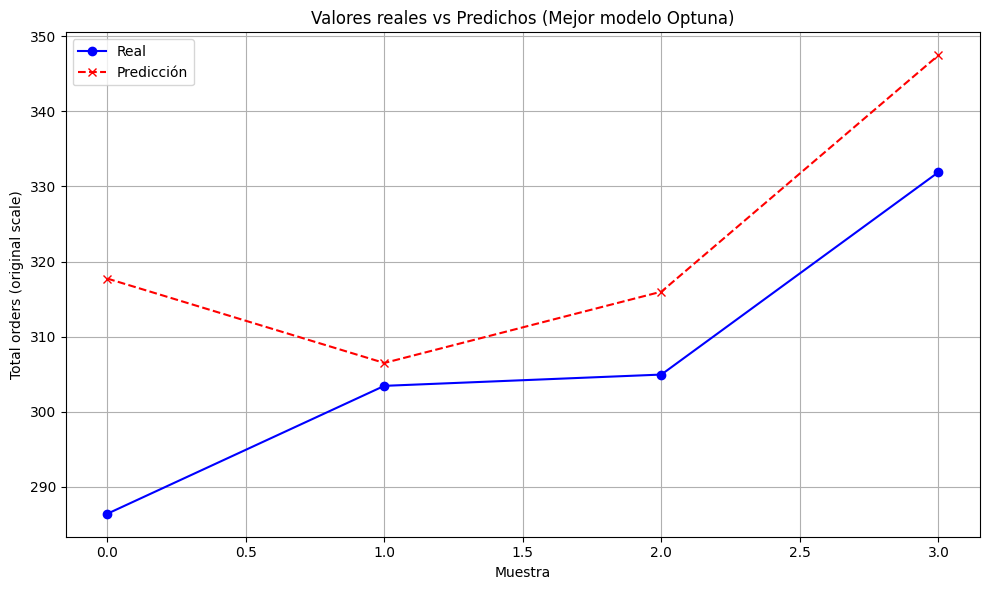

In [124]:

y_pred_norm = model.predict(X_test)

# inevrtir la normalización para y_pred y y_test
y_pred = scaler.inverse_transform(np.hstack([np.zeros((y_pred_norm.shape[0], df.shape[1]-1)), y_pred_norm]))[:, -1]
y_real = scaler.inverse_transform(np.hstack([np.zeros((y_test.shape[0], df.shape[1]-1)), y_test.reshape(-1, 1)]))[:, -1]

# Calcular MAE y RMSE
mae = mean_absolute_error(y_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_real, y_pred))

print(f"MAE en test (original): {mae:.2f}")
print(f"RMSE en test (original): {rmse:.2f}")

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(y_real, label='Real', color='blue', marker='o')
plt.plot(y_pred, label='Predicción', color='red', linestyle='--', marker='x')
plt.title('Valores reales vs Predichos (Mejor modelo Optuna)')
plt.xlabel('Muestra')
plt.ylabel('Total orders (original scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


El proceso de optimización de hiperparámetros utilizando Optuna no resultó en una mejora significativa con respecto al modelo original. A pesar de la búsqueda de hiperparámetros como el número de filtros, el tamaño del kernel, las unidades densas y la tasa de aprendizaje, los valores de MAE y RMSE permanecieron casi iguales. Esto puede deberse a que el modelo base ya estaba bastante optimizado y cercano a su límite de rendimiento. Además, el espacio de búsqueda de hiperparámetros podría no haber sido lo suficientemente amplio como para generar mejoras notables. Sin embargo, el modelo sigue siendo funcional y proporciona resultados aceptables.

### MLP1

In [143]:

mlp_model_1 = Sequential([
    Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),  # aplana la entrada 2D (timesteps, features)
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(1)  # salida regresión
])

mlp_model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = mlp_model_1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100


/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.4797 - mae: 0.6089 - val_loss: 0.1724 - val_mae: 0.3872
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2269 - mae: 0.4149 - val_loss: 0.1538 - val_mae: 0.3664
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1385 - mae: 0.2875 - val_loss: 0.1375 - val_mae: 0.3450
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0862 - mae: 0.2262 - val_loss: 0.1265 - val_mae: 0.3287
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0615 - mae: 0.2026 - val_loss: 0.1184 - val_mae: 0.3160
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0454 - mae: 0.1661 - val_loss: 0.1111 - val_mae: 0.3041
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0423 - mae: 0.1572 - val_loss: 0.1070 - val_mae: 0.2971
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0367 - mae: 0.1560 - val_loss: 0.1043 - val_mae: 0.2923
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0350 - mae: 0.1425 - val

In [144]:
# Evaluación en test
loss, mae = mlp_model_1.evaluate(X_test, y_test, verbose=0)
print(f"MAE (normalizado): {mae:.4f}")


MAE (normalizado): 0.1202


In [ ]:
# Predicción
y_pred_mlp_norm = mlp_model_1.predict(X_test)

# Desnormalizar
y_pred_mlp = scaler.inverse_transform(np.hstack([np.zeros((y_pred_mlp_norm.shape[0], df.shape[1]-1)), y_pred_mlp_norm]))[:, -1]
y_test_original = scaler.inverse_transform(np.hstack([np.zeros((y_test.shape[0], df.shape[1]-1)), y_test.reshape(-1, 1)]))[:, -1]

mae_mlp = mean_absolute_error(y_test_original, y_pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_test_original, y_pred_mlp))

print(f"MAE (original): {mae_mlp:.2f}")
print(f"RMSE (original): {rmse_mlp:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
MAE (original): 58.56
RMSE (original): 66.82


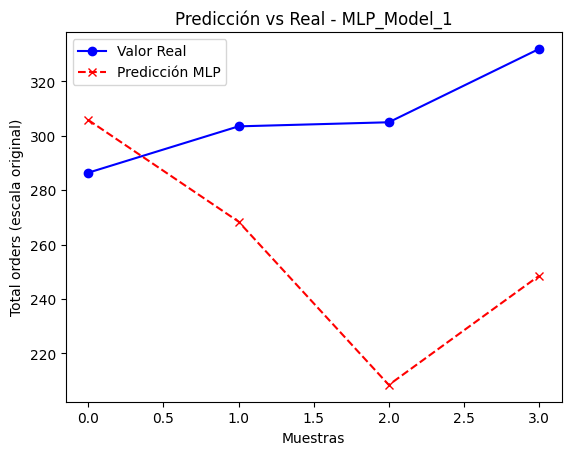

In [149]:
plt.plot(y_test_original, label='Valor Real', color='blue', marker='o')
plt.plot(y_pred_mlp, label='Predicción MLP', color='red', linestyle='--', marker='x')
plt.title('Predicción vs Real - MLP_Model_1')
plt.xlabel('Muestras')
plt.ylabel('Total orders (escala original)')
plt.legend()
plt.show()


El modelo MLP1 utiliza capas densas  junto con la normalización por lotes (BatchNormalization) para mejorar la estabilidad del entrenamiento. Después de entrenar el modelo durante 100 épocas, los resultados obtenidos fueron un MAE de 58 y un RMSE de 66. Aunque el modelo logra una buena aproximación, los resultados sugieren que aún hay espacio para mejorar la precisión, especialmente en la predicción de valores más altos.  Es una muy mala predicción.

### MLP2

In [190]:

mlp_model_2 = Sequential([
    Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(1)  # salida de regresión
])


mlp_model_2.compile(optimizer='adam', loss='mse', metrics=['mae'])


history = mlp_model_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100


/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.4218 - mae: 0.5418 - val_loss: 0.0437 - val_mae: 0.1456
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1098 - mae: 0.2414 - val_loss: 0.0340 - val_mae: 0.1691
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0881 - mae: 0.2162 - val_loss: 0.0520 - val_mae: 0.2056
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1156 - mae: 0.2783 - val_loss: 0.0348 - val_mae: 0.1765
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1332 - mae: 0.2853 - val_loss: 0.0226 - val_mae: 0.1202
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1021 - mae: 0.2499 - val_loss: 0.0347 - val_mae: 0.1303
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0693 - mae: 0.2202 - val_loss: 0.0556 - val_mae: 0.1913
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0911 - mae: 0.2263 - val_loss: 0.0577 - val_mae: 0.2006
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0823 - mae: 0.2127 - val

In [191]:
# Evaluar en test
loss, mae = mlp_model_2.evaluate(X_test, y_test, verbose=0)
print(f"MAE (normalizado): {mae:.4f}")

# Predicciones
y_pred_norm = mlp_model_2.predict(X_test)

# Invertir normalización
y_pred = scaler.inverse_transform(np.hstack([
    np.zeros((y_pred_norm.shape[0], df.shape[1]-1)), y_pred_norm
]))[:, -1]

y_test_original = scaler.inverse_transform(np.hstack([
    np.zeros((y_test.shape[0], df.shape[1]-1)), y_test.reshape(-1, 1)
]))[:, -1]

mae_original = mean_absolute_error(y_test_original, y_pred)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred))

print(f"MAE (original): {mae_original:.2f}")
print(f"RMSE (original): {rmse_original:.2f}")


MAE (normalizado): 0.0273
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE (original): 13.27
RMSE (original): 18.60


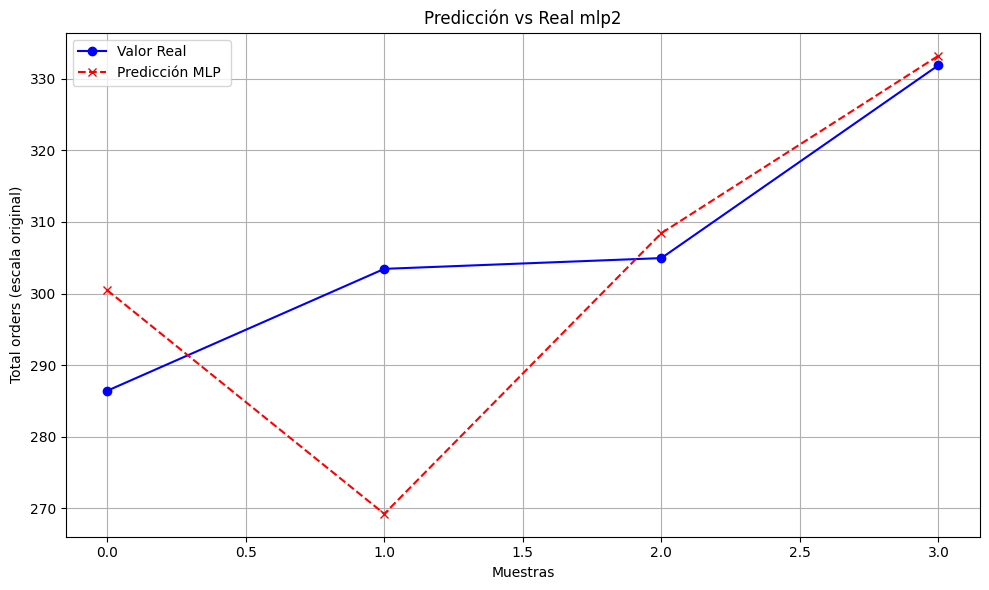

In [192]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Valor Real', color='blue', marker='o')
plt.plot(y_pred, label='Predicción MLP ', color='red', linestyle='--', marker='x')
plt.title('Predicción vs Real mlp2')
plt.xlabel('Muestras')
plt.ylabel('Total orders (escala original)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


El modelo MLP2 introduce capas de Dropout (0.3 y 0.2) para prevenir el sobreajuste y mejorar la generalización. Utiliza una arquitectura con capas densas de 128 y 64 unidades, activadas por ReLU. Después de entrenar durante 100 épocas, el modelo logró un MAE de 13.27 y un RMSE de 18.60, lo que indica una mejora significativa en comparación con el modelo anterior. La incorporación del Dropout parece haber tenido un efecto positivo, reduciendo el sobreajuste y mejorando la capacidad de generalización del modelo. Estos resultados sugieren que el modelo está más equilibrado en términos de precisión y ajuste.

### MLP3

In [ ]:
mlp_model_3 = Sequential([
    Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),

    Dense(128, activation='relu'),
    Dropout(0.3), 

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(32, activation='relu'),  # nueva capa más pequeña

    Dense(1)  # capa de salida para regresión
])

mlp_model_3.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = mlp_model_3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  
    batch_size=32,
    verbose=1
)


Epoch 1/100


/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0943 - mae: 0.2388 - val_loss: 0.0929 - val_mae: 0.2665
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0888 - mae: 0.2189 - val_loss: 0.0668 - val_mae: 0.2096
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0690 - mae: 0.2092 - val_loss: 0.0311 - val_mae: 0.1452
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0946 - mae: 0.2507 - val_loss: 0.0239 - val_mae: 0.1380
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1238 - mae: 0.2807 - val_loss: 0.0315 - val_mae: 0.1554
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0414 - mae: 0.1631 - val_loss: 0.0432 - val_mae: 0.1641
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0502 - mae: 0.1817 - val_loss: 0.0550 - val_mae: 0.1731
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0445 - mae: 0.1675 - val_loss: 0.0539 - val_mae: 0.1721
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0476 - mae: 0.1673 - val

In [198]:
# Evaluar
loss, mae = mlp_model_3.evaluate(X_test, y_test, verbose=0)
print(f"MAE (normalizado): {mae:.4f}")

# Predicción y desescalado
y_pred_norm = mlp_model_3.predict(X_test)
y_pred = scaler.inverse_transform(np.hstack([
    np.zeros((y_pred_norm.shape[0], df.shape[1]-1)), y_pred_norm
]))[:, -1]
y_test_original = scaler.inverse_transform(np.hstack([
    np.zeros((y_test.shape[0], df.shape[1]-1)), y_test.reshape(-1, 1)
]))[:, -1]

mae_original = mean_absolute_error(y_test_original, y_pred)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred))

print(f"MAE (original): {mae_original:.2f}")
print(f"RMSE (original): {rmse_original:.2f}")



MAE (normalizado): 0.0192
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
MAE (original): 9.36
RMSE (original): 12.16


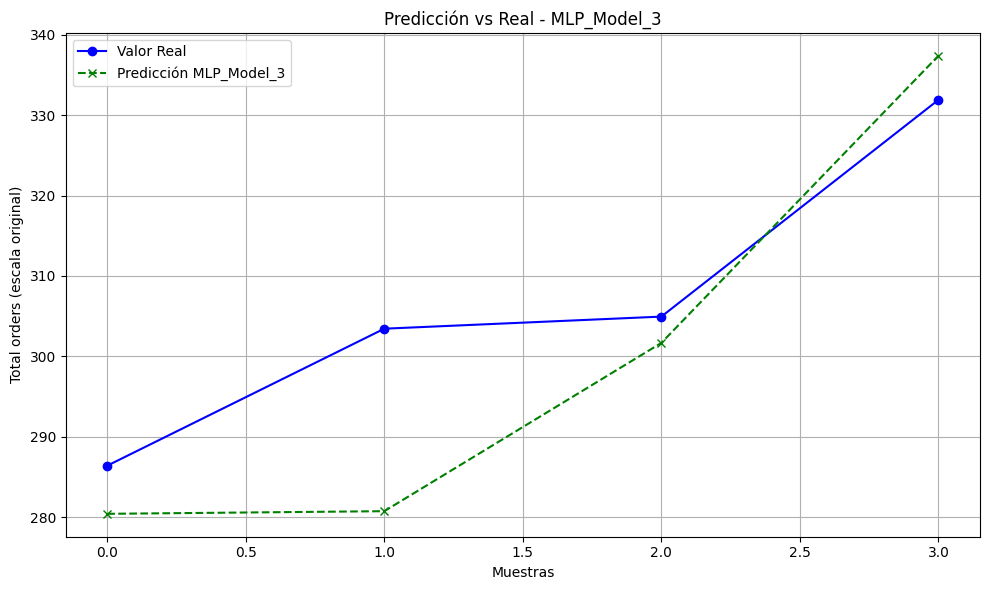

In [199]:

# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Valor Real', color='blue', marker='o')
plt.plot(y_pred, label='Predicción MLP_Model_3', color='green', linestyle='--', marker='x')
plt.title('Predicción vs Real - MLP_Model_3')
plt.xlabel('Muestras')
plt.ylabel('Total orders (escala original)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

El modelo MLP3 incorpora una capa adicional con 32 unidades, después de las capas con 128 y 64 unidades, ambas con Dropout (0.3 y 0.2) para prevenir el sobreajuste. Tras entrenar durante 100 épocas, el modelo alcanzó un MAE de 9.36 y un RMSE de 12.16, lo que muestra una notable mejora con respecto a los modelos anteriores. La adición de la capa más pequeña parece haber permitido una mejor adaptación del modelo a los datos, mientras que el Dropout sigue siendo útil para la regularización.

### OPTUNA MLP

In [220]:
def objective(trial: Trial):
    # Hiperparámetros para mejorar
    units_1 = trial.suggest_int('units_1', 64, 256, step=32)
    units_2 = trial.suggest_int('units_2', 32, 128, step=16)
    units_3 = trial.suggest_int('units_3', 16, 64, step=8)
    
    dropout_1 = trial.suggest_float('dropout_1', 0.1, 0.5)
    dropout_2 = trial.suggest_float('dropout_2', 0.1, 0.4)

    learning_rate = trial.suggest_float('lr', 1e-4, 1e-2, log=True)

    # Modelo, badaso en mlpo3
    model = Sequential([
        Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),

        Dense(units_1, activation='relu'),
        Dropout(dropout_1),

        Dense(units_2, activation='relu'),
        Dropout(dropout_2),

        Dense(units_3, activation='relu'),

        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        verbose=0
    )

    val_loss = history.history['val_loss'][-1]
    return val_loss


In [221]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)


[I 2025-04-06 12:48:58,979] A new study created in memory with name: no-name-2a95a2ee-693a-45bc-848f-31682fe7cc2d
/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-04-06 12:49:01,760] Trial 0 finished with value: 0.03816361352801323 and parameters: {'units_1': 224, 'units_2': 64, 'units_3': 16, 'dropout_1': 0.3212180323586178, 'dropout_2': 0.13775316787144737, 'lr': 0.0002361774342454091}. Best is trial 0 with value: 0.03816361352801323.
[I 2025-04-06 12:49:04,387] Trial 1 finished with value: 0.0388362817466259 and parameters: {'units_1': 160, 'units_2': 80, 'units_3': 48, 'dropout_1': 0.33853458777465795, 'dropout_2': 0.2330442117732551, 'lr': 0.0001223711103587474}. Best is trial 0 wi

In [222]:
best_params = study.best_trial.params
print("Mejores hiperparámetros:", best_params)

# Entrenar modelo final con mejores params
best_mlp = Sequential([
    Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),

    Dense(best_params['units_1'], activation='relu'),
    Dropout(best_params['dropout_1']),

    Dense(best_params['units_2'], activation='relu'),
    Dropout(best_params['dropout_2']),

    Dense(best_params['units_3'], activation='relu'),

    Dense(1)
])

best_mlp.compile(optimizer=Adam(learning_rate=best_params['lr']), loss='mse', metrics=['mae'])

history = best_mlp.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Mejores hiperparámetros: {'units_1': 128, 'units_2': 80, 'units_3': 56, 'dropout_1': 0.17174685054063937, 'dropout_2': 0.24714766002071983, 'lr': 0.0005737314732005281}
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2029 - mae: 0.3661 - val_loss: 0.0254 - val_mae: 0.1394
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0834 - mae: 0.2316 - val_loss: 0.0370 - val_mae: 0.1535
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1125 - mae: 0.2667 - val_loss: 0.0616 - val_mae: 0.2237
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0762 - mae: 0.2087 - val_loss: 0.0555 - val_mae: 0.2120
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1022 - mae: 0.2778 - val_loss: 0.0332 - val_mae: 0.1486
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0530 - mae: 0.1809 - val_loss: 0.0183 - val_mae: 0.1086
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0693 - mae: 0.2063 - val_loss: 0.0132 - val_mae: 0.0811
Epoch 8/100
2/2 ━━━

In [223]:
# Evaluar
loss, mae = best_mlp.evaluate(X_test, y_test, verbose=0)
print(f"MAE (normalizado): {mae:.4f}")

# Predicción y desescalado
y_pred_norm = best_mlp.predict(X_test)
y_pred = scaler.inverse_transform(np.hstack([
    np.zeros((y_pred_norm.shape[0], df.shape[1]-1)), y_pred_norm
]))[:, -1]
y_test_original = scaler.inverse_transform(np.hstack([
    np.zeros((y_test.shape[0], df.shape[1]-1)), y_test.reshape(-1, 1)
]))[:, -1]

mae_original = mean_absolute_error(y_test_original, y_pred)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred))

print(f"MAE (original): {mae_original:.2f}")
print(f"RMSE (original): {rmse_original:.2f}")


MAE (normalizado): 0.0349
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE (original): 16.99
RMSE (original): 17.48


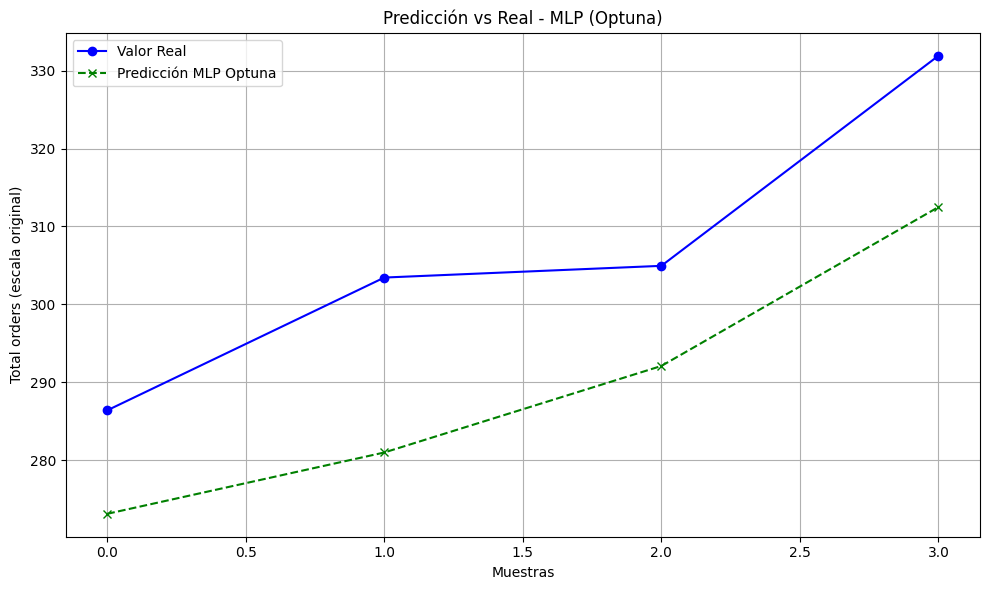

In [224]:
# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Valor Real', color='blue', marker='o')
plt.plot(y_pred, label='Predicción MLP Optuna', color='green', linestyle='--', marker='x')
plt.title('Predicción vs Real - MLP (Optuna)')
plt.xlabel('Muestras')
plt.ylabel('Total orders (escala original)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Este modelo optuna busca mejorar la arquitectura de la red neuronal MLP3 optimizando hiperparámetros como el número de unidades en cada capa (units_1, units_2, units_3), las tasas de dropout y la tasa de aprendizaje. A través de la búsqueda de hiperparámetros con Optuna, el modelo experimenta con diferentes configuraciones, buscando minimizar la pérdida de validación. Después de entrenar durante 100 épocas, el modelo alcanzó un MAE de 16.99 y un RMSE de 17.48, lo que indica que, aunque la precisión ha mejorado ligeramente en comparación con el modelo anterior, los resultados siguen siendo consistentes, con un rendimiento que se aproxima al modelo previo en términos de error absoluto y cuadrático.

### LSTM 1

In [ ]:
lstm_model_1 = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)),  # 64 unidades en la primera capa LSTM
    LSTM(32, activation='relu'), 
    Dropout(0.3),  
    Dense(1)  
], name='LSTM_Model_1')


lstm_model_1.summary()

/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "LSTM_Model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 6, 64)          │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_651 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2240 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,161 (125.63 KB)

 Trainable params: 32,161 (125.63 KB)

 Non-trainable params: 0 (0.00 B)

In [255]:
lstm_model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = lstm_model_1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  
    batch_size=32,
    verbose=1
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.1869 - mae: 0.3871 - val_loss: 0.1022 - val_mae: 0.2907
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1021 - mae: 0.2705 - val_loss: 0.0584 - val_mae: 0.2024
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0758 - mae: 0.1958 - val_loss: 0.0290 - val_mae: 0.1203
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0435 - mae: 0.1715 - val_loss: 0.0175 - val_mae: 0.1177
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0434 - mae: 0.1572 - val_loss: 0.0185 - val_mae: 0.1187
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0443 - mae: 0.1715 - val_loss: 0.0229 - val_mae: 0.1380
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0634 - mae: 0.2003 - val_loss: 0.0230 - val_mae: 0.1387
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0485 - mae: 0.1715 - val_loss: 0.0196 - val_mae: 0.1251
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0494 - mae:

In [ ]:
# Evaluar
loss, mae = lstm_model_1.evaluate(X_test, y_test, verbose=0)
print(f"MAE (normalizado): {mae:.4f}")

# Predicción y desescalado
y_pred_norm = lstm_model_1.predict(X_test)
y_pred = scaler.inverse_transform(np.hstack([
    np.zeros((y_pred_norm.shape[0], df.shape[1]-1)), y_pred_norm
]))[:, -1]
y_test_original = scaler.inverse_transform(np.hstack([
    np.zeros((y_test.shape[0], df.shape[1]-1)), y_test.reshape(-1, 1)
]))[:, -1]

mae_original = mean_absolute_error(y_test_original, y_pred)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred))

print(f"MAE (original): {mae_original:.2f}")
print(f"RMSE (original): {rmse_original:.2f}")



MAE (normalizado): 0.0121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
MAE (original): 5.91
RMSE (original): 6.72


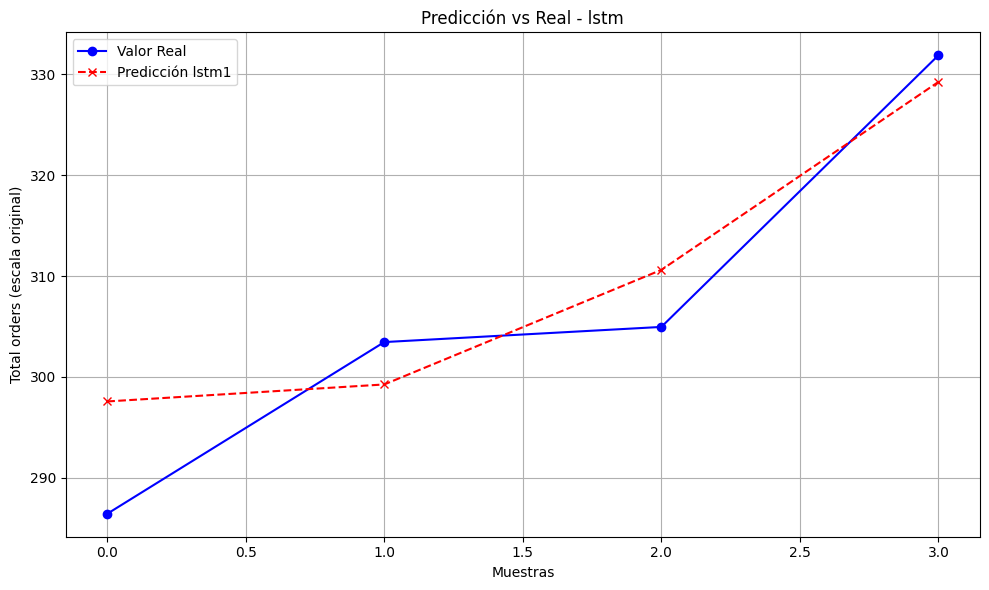

In [257]:

# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Valor Real', color='blue', marker='o')
plt.plot(y_pred, label='Predicción lstm1', color='red', linestyle='--', marker='x')
plt.title('Predicción vs Real - lstm')
plt.xlabel('Muestras')
plt.ylabel('Total orders (escala original)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Este modelo LSTM_Model_1 está basado en una arquitectura de red neuronal recurrente con dos capas LSTM, diseñadas para aprender patrones secuenciales a partir de los datos temporales. La primera capa LSTM tiene 64 unidades y está configurada para devolver secuencias , lo que permite que la salida de esta capa se pase a la siguiente capa LSTM. La segunda capa LSTM tiene 32 unidades y está seguida por una capa de Dropout con una tasa de 0.3 para prevenir el sobreajuste.

La capa final es una capa densa con una sola unidad para producir la salida de regresión. El modelo fue entrenado para predecir un valor continuo, y los resultados muestran un MAE  de 5.91 y un RMSE de 6.72. El modelo tuvo buenos resltados y parece ajustarse biena los datos reales

### LSTM 2

In [286]:
lstm_model_2 = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)),  
    LSTM(64, activation='relu'), 
    Dropout(0.3),  
    Dense(1)  
], name='LSTM_Model_2')

/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [287]:
lstm_model_2.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = lstm_model_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,  
    batch_size=32,
    verbose=1
)

Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.1413 - mae: 0.3246 - val_loss: 0.0724 - val_mae: 0.2330
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0825 - mae: 0.2169 - val_loss: 0.0342 - val_mae: 0.1306
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0378 - mae: 0.1341 - val_loss: 0.0186 - val_mae: 0.1241
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0375 - mae: 0.1493 - val_loss: 0.0179 - val_mae: 0.1235
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0334 - mae: 0.1465 - val_loss: 0.0177 - val_mae: 0.1233
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0272 - mae: 0.1291 - val_loss: 0.0179 - val_mae: 0.1233
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0378 - mae: 0.1609 - val_loss: 0.0191 - val_mae: 0.1233
Epoch 8/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0377 - mae: 0.1461 - val_loss: 0.0210 - val_mae: 0.1233
Epoch 9/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0316 - mae:

In [ ]:
# Evaluar
loss, mae = lstm_model_2.evaluate(X_test, y_test, verbose=0)
print(f"MAE (normalizado): {mae:.4f}")

# Predicción y desescalado
y_pred_norm = lstm_model_2.predict(X_test)
y_pred = scaler.inverse_transform(np.hstack([
    np.zeros((y_pred_norm.shape[0], df.shape[1]-1)), y_pred_norm
]))[:, -1]
y_test_original = scaler.inverse_transform(np.hstack([
    np.zeros((y_test.shape[0], df.shape[1]-1)), y_test.reshape(-1, 1)
]))[:, -1]

mae_original = mean_absolute_error(y_test_original, y_pred)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred))

print(f"MAE (original): {mae_original:.2f}")
print(f"RMSE (original): {rmse_original:.2f}")



MAE (normalizado): 0.0698
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
MAE (original): 34.00
RMSE (original): 40.56


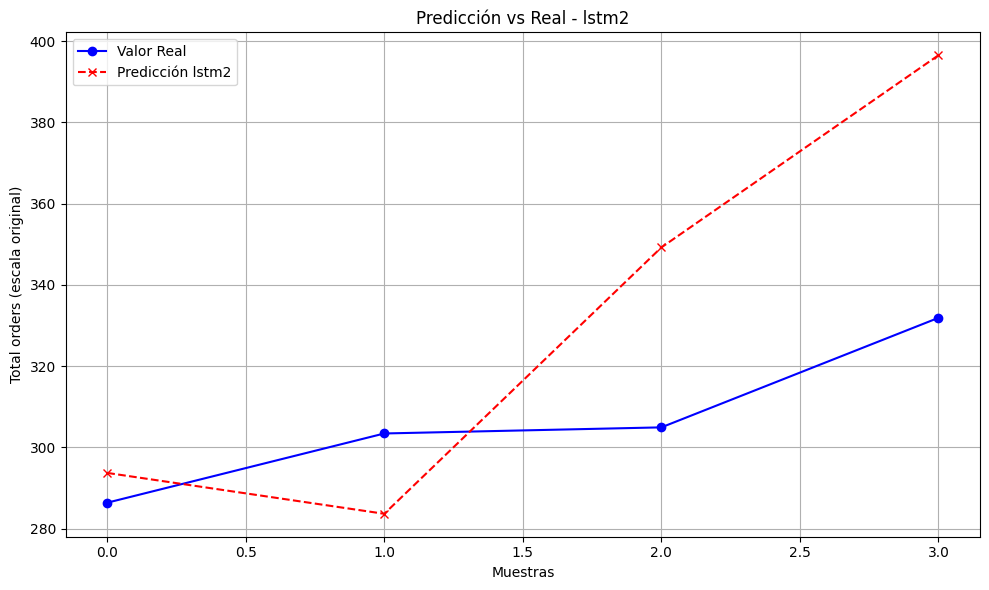

In [289]:

# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Valor Real', color='blue', marker='o')
plt.plot(y_pred, label='Predicción lstm2', color='red', linestyle='--', marker='x')
plt.title('Predicción vs Real - lstm2')
plt.xlabel('Muestras')
plt.ylabel('Total orders (escala original)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

El modelo LSTM_Model_2 presenta una arquitectura LSTM con dos capas, diseñadas para aprender de secuencias temporales de los datos. La primera capa LSTM tiene 128 unidades y devuelve secuencias , permitiendo que la salida de esta capa se pase a la siguiente capa LSTM. La segunda capa LSTM tiene 64 unidades. Después de las capas LSTM, se incluye una capa de Dropout con una tasa de 0.3 para prevenir el sobreajuste.

La capa final es una capa densa con una sola unidad que proporciona la salida para la regresión. Sin embargo, los resultados muestran un MAE de 34.00 y un RMSE de 40.56, que son significativamente más altos en comparación con los resultados obtenidos en el LSTM_Model_1. Esto sugiere que, a pesar de contar con más unidades en las capas LSTM, el modelo podría estar sufriendo un problema de sobreajuste o no estar bien optimizado para los datos en cuestión.

Aunque este modelo tiene más capacidad en términos de unidades LSTM, los resultados sugieren que la complejidad adicional podría no haber ayudado a mejorar la precisión en la predicción, y podrían requerirse ajustes en la arquitectura, el entrenamiento o la regularización para mejorar su rendimiento.

### LSTM3

In [ ]:
lstm_model_3 = Sequential([
    LSTM(64, activation='tanh', input_shape=(n_steps, n_features)), 
    Dropout(0.3),  
    Dense(32, activation='tanh'), 
    Dense(1)  
])


/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [279]:
lstm_model_3.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = lstm_model_3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,  # más épocas por la nueva capa
    batch_size=32,
    verbose=1
)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0164 - mae: 0.0926 - val_loss: 0.0170 - val_mae: 0.1044
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0079 - mae: 0.0736 - val_loss: 0.0207 - val_mae: 0.0891
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0149 - mae: 0.0849 - val_loss: 0.0178 - val_mae: 0.0951
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0139 - mae: 0.0857 - val_loss: 0.0173 - val_mae: 0.1200
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0134 - mae: 0.0924 - val_loss: 0.0175 - val_mae: 0.1206
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0158 - mae: 0.1023 - val_loss: 0.0174 - val_mae: 0.1036
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0081 - mae: 0.0726 - val_loss: 0.0188 - val_mae: 0.0935
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0135 - mae: 0.0833 - val_loss: 0.0193 - val_mae: 0.0944
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0121 - mae: 

In [ ]:
# Evaluar
loss, mae = lstm_model_3.evaluate(X_test, y_test, verbose=0)
print(f"MAE (normalizado): {mae:.4f}")

# Predicción y desescalado
y_pred_norm = lstm_model_3.predict(X_test)
y_pred = scaler.inverse_transform(np.hstack([
    np.zeros((y_pred_norm.shape[0], df.shape[1]-1)), y_pred_norm
]))[:, -1]
y_test_original = scaler.inverse_transform(np.hstack([
    np.zeros((y_test.shape[0], df.shape[1]-1)), y_test.reshape(-1, 1)
]))[:, -1]

mae_original = mean_absolute_error(y_test_original, y_pred)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred))

print(f"MAE (original): {mae_original:.2f}")
print(f"RMSE (original): {rmse_original:.2f}")



MAE (normalizado): 0.0497
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
MAE (original): 24.21
RMSE (original): 26.37


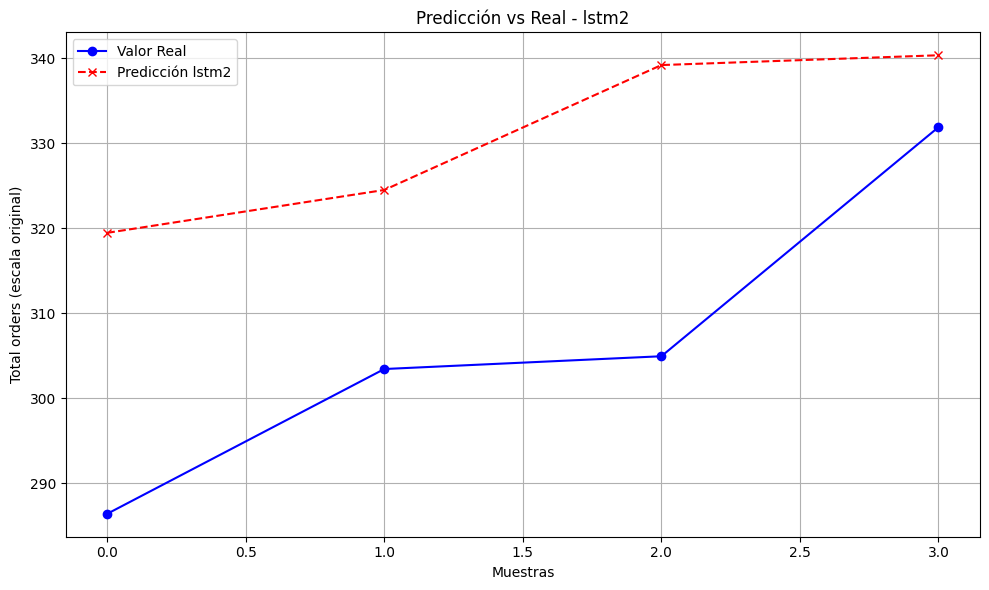

In [281]:

# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Valor Real', color='blue', marker='o')
plt.plot(y_pred, label='Predicción lstm3', color='red', linestyle='--', marker='x')
plt.title('Predicción vs Real - lstm3')
plt.xlabel('Muestras')
plt.ylabel('Total orders (escala original)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

El modelo LSTM_Model_3 está compuesto por una capa LSTM con 64 unidades, usando la función de activación tanh, seguida de una capa de Dropout con una tasa de 0.3 para prevenir el sobreajuste. A continuación, se agrega una capa densa con 32 unidades, también con la función de activación tanh, y una capa de salida con una sola unidad para la regresión.

A pesar de su arquitectura relativamente simple, los resultados muestran un MAE  de 24.21 y un RMSE  de 26.37, que son más altos en comparación con los modelos anteriores. Esto sugiere que el modelo no está logrando una predicción tan precisa en comparación con otros enfoques.

El uso de la función de activación tanh en lugar de relu podría estar afectando el rendimiento, ya que tanh tiende a ser más susceptible a problemas de desvanecimiento del gradiente, especialmente en redes profundas.

### LSTM OPTUNA

In [ ]:

def objective(trial):
    # Definir los hiperparámetros a optimizar
    units_lstm_1 = trial.suggest_int('units_lstm_1', 32, 128) 
    units_lstm_2 = trial.suggest_int('units_lstm_2', 16, 64)  
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)  
    
    # Crear el modelo LSTM
    model = Sequential([
        LSTM(units_lstm_1, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)),  # 1ra capa LSTM
        LSTM(units_lstm_2, activation='relu'), 
        Dropout(dropout_rate),  
        Dense(1)
    ])
    

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)
    
    val_mae = history.history['val_mae'][-1]
    
    return val_mae


In [293]:
study = optuna.create_study(direction='minimize') 
study.optimize(objective, n_trials=50) 

print(f'Best hyperparameters: {study.best_params}')

[I 2025-04-06 13:32:13,291] A new study created in memory with name: no-name-095440d1-684f-42eb-ad40-007948134554
/var/folders/vj/k67r6tzn6k3gd90ph1hz0kbr0000gn/T/ipykernel_4591/280954150.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)  # Tasa de aprendizaje (loguniform)
/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-04-06 13:32:15,613] Trial 0 finished with value: 0.12422666698694229 and parameters: {'units_lstm_1': 98, 'units_lstm_2': 25, 'dropout_rate': 0.3975

Best hyperparameters: {'units_lstm_1': 103, 'units_lstm_2': 32, 'dropout_rate': 0.30231724364827495, 'learning_rate': 0.0009605411944653367}


In [294]:

# Cmejores hiper para el modelo
best_params = study.best_params
lstm_model_optimized = Sequential([
    LSTM(best_params['units_lstm_1'], activation='relu', return_sequences=True, input_shape=(n_steps, n_features)),
    LSTM(best_params['units_lstm_2'], activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(1)
])

lstm_model_optimized.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mse', metrics=['mae'])

history_optimized = lstm_model_optimized.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val), 
    epochs=100, 
    batch_size=32, 
    verbose=1
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.2373 - mae: 0.4466 - val_loss: 0.1281 - val_mae: 0.3315
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1550 - mae: 0.3471 - val_loss: 0.0928 - val_mae: 0.2732
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1113 - mae: 0.2794 - val_loss: 0.0652 - val_mae: 0.2171
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0758 - mae: 0.2081 - val_loss: 0.0434 - val_mae: 0.1595
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0493 - mae: 0.1416 - val_loss: 0.0273 - val_mae: 0.1251
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0382 - mae: 0.1396 - val_loss: 0.0192 - val_mae: 0.1247
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0353 - mae: 0.1519 - val_loss: 0.0183 - val_mae: 0.1242
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0426 - mae: 0.1626 - val_loss: 0.0189 - val_mae: 0.1239
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0531 - mae:

In [ ]:
# Evaluar
loss, mae = lstm_model_optimized.evaluate(X_test, y_test, verbose=0)  # Usamos el modelo optimizado de Optuna
print(f"MAE (normalizado): {mae:.4f}")

# Predicción y desescalado
y_pred_norm = lstm_model_optimized.predict(X_test)
y_pred = scaler.inverse_transform(np.hstack([
    np.zeros((y_pred_norm.shape[0], df.shape[1]-1)), y_pred_norm
]))[:, -1]
y_test_original = scaler.inverse_transform(np.hstack([
    np.zeros((y_test.shape[0], df.shape[1]-1)), y_test.reshape(-1, 1)
]))[:, -1]

mae_original = mean_absolute_error(y_test_original, y_pred)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred))

print(f"MAE (original): {mae_original:.2f}")
print(f"RMSE (original): {rmse_original:.2f}")


MAE (normalizado): 0.0714
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
MAE (original): 34.80
RMSE (original): 37.64


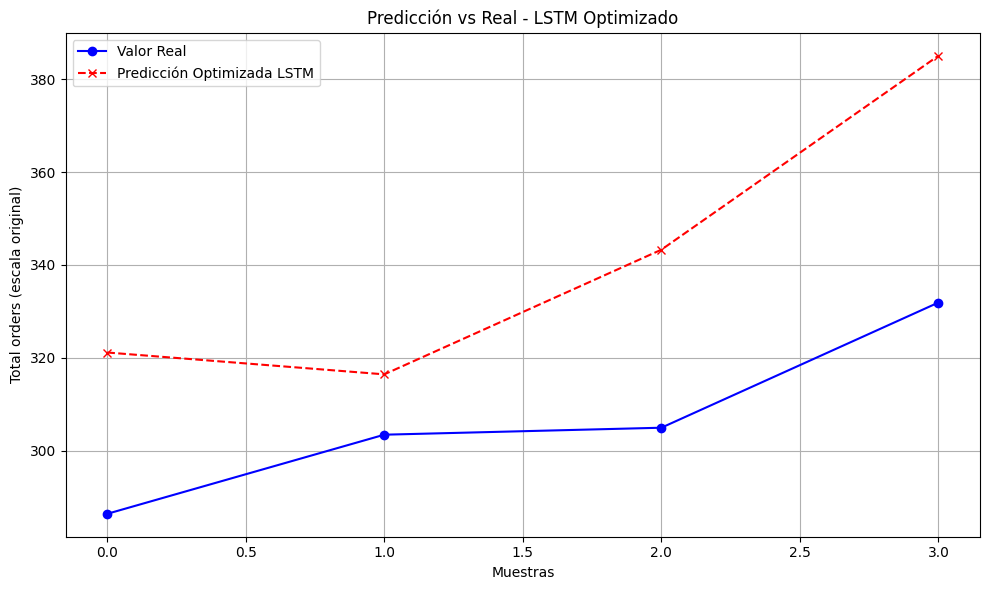

In [296]:

# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Valor Real', color='blue', marker='o')
plt.plot(y_pred, label='Predicción Optimizada LSTM', color='red', linestyle='--', marker='x')
plt.title('Predicción vs Real - LSTM Optimizado')
plt.xlabel('Muestras')
plt.ylabel('Total orders (escala original)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


 La arquitectura consiste en dos capas LSTM, con unidades de tamaño ajustable (units_lstm_1 y units_lstm_2), una capa de Dropout para reducir el sobreajuste, y una capa densa para la salida.

Los resultados muestran un MAE de 34.80 y un RMSE  de 37.64, que son relativamente altos. Aunque la optimización de hiperparámetros ha ajustado las capas LSTM, el modelo aún no alcanza un rendimiento destacado en comparación con otros modelos previos.



### CNN-LSTM 1

In [306]:
cnnlstm_model_1 = Sequential([
    Conv1D(128, 2, activation=LeakyReLU(alpha=0.1), padding='same', input_shape=(n_steps, n_features)),
    MaxPooling1D(2),
    TimeDistributed(Dense(30, activation=LeakyReLU(alpha=0.1))),
    LSTM(64, activation='relu'),
    Dense(1)
], name='CNN_LSTM_Model_1')

cnnlstm_model_1.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [307]:
history = cnnlstm_model_1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    verbose=1
)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.1910 - mae: 0.4021 - val_loss: 0.1441 - val_mae: 0.3549
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1523 - mae: 0.3439 - val_loss: 0.1071 - val_mae: 0.2987
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1191 - mae: 0.2919 - val_loss: 0.0766 - val_mae: 0.2422
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0854 - mae: 0.2287 - val_loss: 0.0495 - val_mae: 0.1785
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0576 - mae: 0.1678 - val_loss: 0.0290 - val_mae: 0.1234
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0372 - mae: 0.1318 - val_loss: 0.0190 - val_mae: 0.1228
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0295 - mae: 0.1278 - val_loss: 0.0176 - val_mae: 0.1219
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0308 - mae: 0.1465 - val_loss: 0.0178 - val_mae: 0.1215
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0307 - mae:

In [ ]:
# Evaluar
loss, mae = cnnlstm_model_1.evaluate(X_test, y_test, verbose=0)
print(f"MAE (normalizado): {mae:.4f}")

# Predicción y desescalado
y_pred_norm = cnnlstm_model_1.predict(X_test)
y_pred = scaler.inverse_transform(np.hstack([
    np.zeros((y_pred_norm.shape[0], df.shape[1]-1)), y_pred_norm
]))[:, -1]
y_test_original = scaler.inverse_transform(np.hstack([
    np.zeros((y_test.shape[0], df.shape[1]-1)), y_test.reshape(-1, 1)
]))[:, -1]

mae_original = mean_absolute_error(y_test_original, y_pred)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred))

print(f"MAE (original): {mae_original:.2f}")
print(f"RMSE (original): {rmse_original:.2f}")



MAE (normalizado): 0.0119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
MAE (original): 5.79
RMSE (original): 7.06


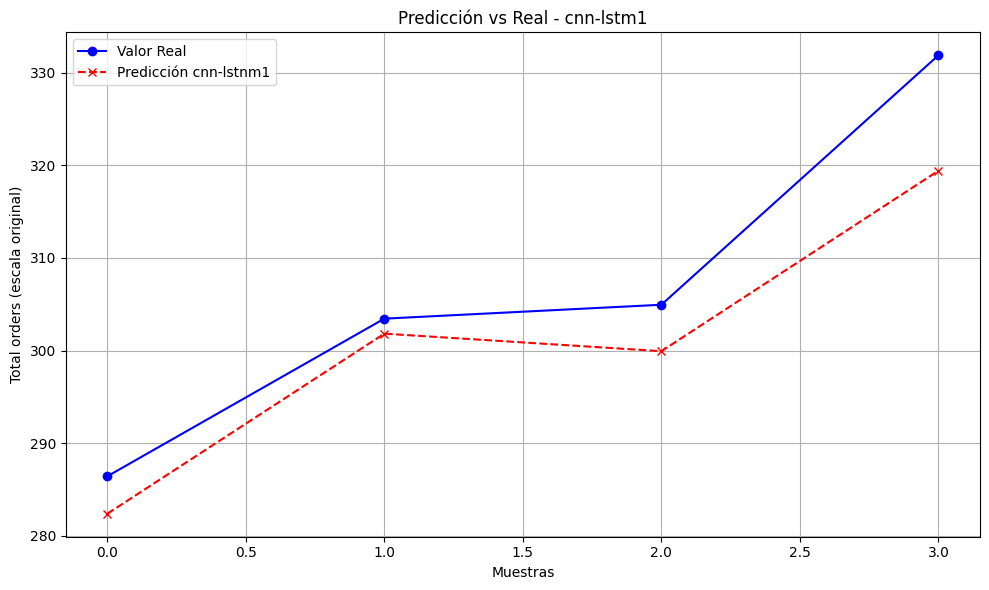

In [310]:

# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Valor Real', color='blue', marker='o')
plt.plot(y_pred, label='Predicción cnn-lstnm1', color='red', linestyle='--', marker='x')
plt.title('Predicción vs Real - cnn-lstm1')
plt.xlabel('Muestras')
plt.ylabel('Total orders (escala original)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

El modelo CNN-LSTM combina una capa convolucional 1D para extraer características locales de la secuencia de entrada, seguida de una capa LSTM para capturar dependencias temporales a lo largo de los pasos de tiempo. En este caso, la primera capa Conv1D utiliza 128 filtros con un kernel de tamaño 2 y activación LeakyReLU para manejar posibles problemas de gradientes nulos, seguida de una capa de MaxPooling1D para reducir la dimensionalidad y prevenir el sobreajuste. A continuación, se utiliza la capa TimeDistributed con una capa densa de 30 unidades, que actúa sobre cada paso de tiempo de la secuencia de manera independiente. La capa LSTM de 64 unidades modela la dependencia temporal a lo largo de la secuencia, y la salida final es una capa densa con una única unidad para realizar la predicción de regresión.

El rendimiento de este modelo es bastante bueno, con un MAE  de 5.79 y un RMSE de 7.06. Estos valores indican que el modelo está proporcionando predicciones razonablemente precisas, con errores no tan grandes, aunque aún se pueden explorar mejoras.

La combinación de CNN para extracción de características locales y LSTM para captura de relaciones temporales es particularmente efectiva cuando se trabaja con secuencias temporales. Para mejorar aún más el rendimiento, se podrían probar técnicas de regularización adicionales, como Dropout, o ajustar los hiperparámetros del modelo mediante optimización.

### CNM-LSTM 2

In [311]:
cnnlstm_model_2 = Sequential([
    Conv1D(64, 3, activation=LeakyReLU(alpha=0.1), padding='same', input_shape=(n_steps, n_features)),
    MaxPooling1D(2),

    Conv1D(32, 3, activation=LeakyReLU(alpha=0.1), padding='same'),
    MaxPooling1D(2),

    TimeDistributed(Dense(25, activation=LeakyReLU(alpha=0.1))),
    Dropout(0.3),  # Regularización

    LSTM(80, activation='tanh'),  # Más unidades LSTM
    Dense(1) 
], name='CNN_LSTM_Model_2')

cnnlstm_model_2.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

cnnlstm_model_2.summary()

/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CNN_LSTM_Model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1230 (Conv1D)            │ (None, 6, 64)          │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1229              │ (None, 3, 64)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1231 (Conv1D)            │ (None, 3, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1230              │ (None, 1, 32)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 1, 25)          │           825 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_764 (Dropout)           │ (None, 1, 25)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_237 (LSTM)                 │ (None, 80)             │        33,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2358 (Dense)              │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,370 (169.41 KB)

 Trainable params: 43,370 (169.41 KB)

 Non-trainable params: 0 (0.00 B)

In [312]:
history = cnnlstm_model_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    verbose=1
)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.1888 - mae: 0.3958 - val_loss: 0.1437 - val_mae: 0.3546
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1654 - mae: 0.3617 - val_loss: 0.1213 - val_mae: 0.3216
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1300 - mae: 0.3152 - val_loss: 0.0932 - val_mae: 0.2744
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1109 - mae: 0.2749 - val_loss: 0.0636 - val_mae: 0.2138
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0787 - mae: 0.2143 - val_loss: 0.0364 - val_mae: 0.1368
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0549 - mae: 0.1518 - val_loss: 0.0195 - val_mae: 0.1248
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0317 - mae: 0.1366 - val_loss: 0.0186 - val_mae: 0.1229
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0368 - mae: 0.1652 - val_loss: 0.0257 - val_mae: 0.1389
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0515 - mae:

In [ ]:
# Evaluar
loss, mae = cnnlstm_model_2.evaluate(X_test, y_test, verbose=0)
print(f"MAE (normalizado): {mae:.4f}")

# Predicción y desescalado
y_pred_norm = cnnlstm_model_2.predict(X_test)
y_pred = scaler.inverse_transform(np.hstack([
    np.zeros((y_pred_norm.shape[0], df.shape[1]-1)), y_pred_norm
]))[:, -1]
y_test_original = scaler.inverse_transform(np.hstack([
    np.zeros((y_test.shape[0], df.shape[1]-1)), y_test.reshape(-1, 1)
]))[:, -1]

mae_original = mean_absolute_error(y_test_original, y_pred)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred))

print(f"MAE (original): {mae_original:.2f}")
print(f"RMSE (original): {rmse_original:.2f}")



MAE (normalizado): 0.0401
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
MAE (original): 19.51
RMSE (original): 22.18


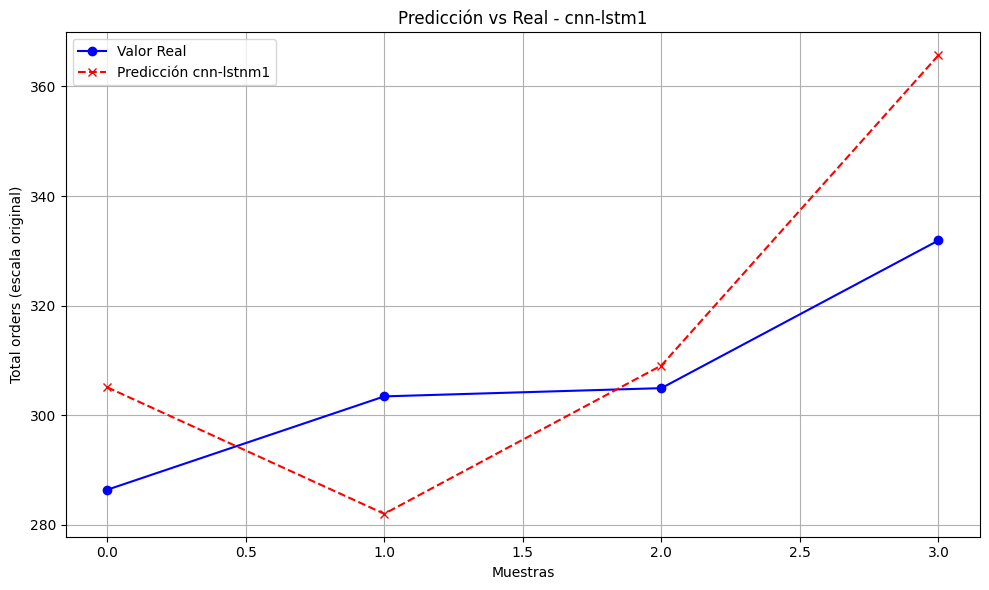

In [316]:

# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Valor Real', color='blue', marker='o')
plt.plot(y_pred, label='Predicción cnn-lstnm1', color='red', linestyle='--', marker='x')
plt.title('Predicción vs Real - cnn-lstm1')
plt.xlabel('Muestras')
plt.ylabel('Total orders (escala original)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

El modelo CNN-LSTM 2 sigue una arquitectura similar al anterior pero con algunos ajustes. Inicia con dos capas convolucionales Conv1D que utilizan LeakyReLU para la activación, lo que ayuda a prevenir los problemas de gradientes nulos durante el entrenamiento. Ambas capas convolucionales están seguidas por capas de MaxPooling1D para reducir la dimensionalidad y, a su vez, reducir la posibilidad de sobreajuste.

A continuación, se aplica una capa TimeDistributed(Dense()) que procesa cada paso de tiempo de la secuencia de forma independiente, seguida de un Dropout(0.3) para regularización, lo que ayuda a evitar el sobreajuste durante el entrenamiento al desactivar aleatoriamente algunas unidades. La capa LSTM con 80 unidades captura las dependencias temporales a lo largo de la secuencia de datos, y finalmente, una capa densa de salida realiza la predicción de regresión.

Aunque este modelo tiene más capas y un mayor número de unidades LSTM que el anterior, su rendimiento es menos eficiente, con un MAE  de 19.51 y un RMSE de 22.18. Estos valores indican un mayor error en las predicciones en comparación con el modelo anterior. A pesar de la mayor complejidad del modelo, puede ser que el aumento de la profundidad y la cantidad de unidades no haya permitido una mejor generalización, lo que podría sugerir la necesidad de ajustar los hiperparámetros, como la tasa de aprendizaje o la cantidad de capas convolucionales.

### CNN-LSTM3

In [318]:
cnnlstm_model_3 = Sequential([
    Conv1D(128, 2, activation=LeakyReLU(alpha=0.1), padding='same', input_shape=(n_steps, n_features)),
    MaxPooling1D(2),
    
    TimeDistributed(Dense(30, activation=LeakyReLU(alpha=0.1))),
    
    LSTM(64, activation='tanh'),  # cabie la activación de la LSTM
    Dense(1)
], name='CNN_LSTM_Model_3')

cnnlstm_model_3.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


In [319]:
history = cnnlstm_model_3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    verbose=1
)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.2100 - mae: 0.4198 - val_loss: 0.0929 - val_mae: 0.2757
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1144 - mae: 0.2859 - val_loss: 0.0402 - val_mae: 0.1531
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0466 - mae: 0.1527 - val_loss: 0.0170 - val_mae: 0.1162
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0288 - mae: 0.1226 - val_loss: 0.0230 - val_mae: 0.1369
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0370 - mae: 0.1678 - val_loss: 0.0294 - val_mae: 0.1528
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0432 - mae: 0.1855 - val_loss: 0.0238 - val_mae: 0.1389
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0354 - mae: 0.1641 - val_loss: 0.0172 - val_mae: 0.1165
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0270 - mae: 0.1319 - val_loss: 0.0176 - val_mae: 0.1176
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0272 - mae:

In [320]:
# Evaluar
loss, mae = cnnlstm_model_3.evaluate(X_test, y_test, verbose=0)
print(f"MAE (normalizado): {mae:.4f}")

# Predicción y desescalado
y_pred_norm = cnnlstm_model_3.predict(X_test)
y_pred = scaler.inverse_transform(np.hstack([
    np.zeros((y_pred_norm.shape[0], df.shape[1]-1)), y_pred_norm
]))[:, -1]
y_test_original = scaler.inverse_transform(np.hstack([
    np.zeros((y_test.shape[0], df.shape[1]-1)), y_test.reshape(-1, 1)
]))[:, -1]

mae_original = mean_absolute_error(y_test_original, y_pred)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred))

print(f"MAE (original): {mae_original:.2f}")
print(f"RMSE (original): {rmse_original:.2f}")



MAE (normalizado): 0.0150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
MAE (original): 7.30
RMSE (original): 7.94


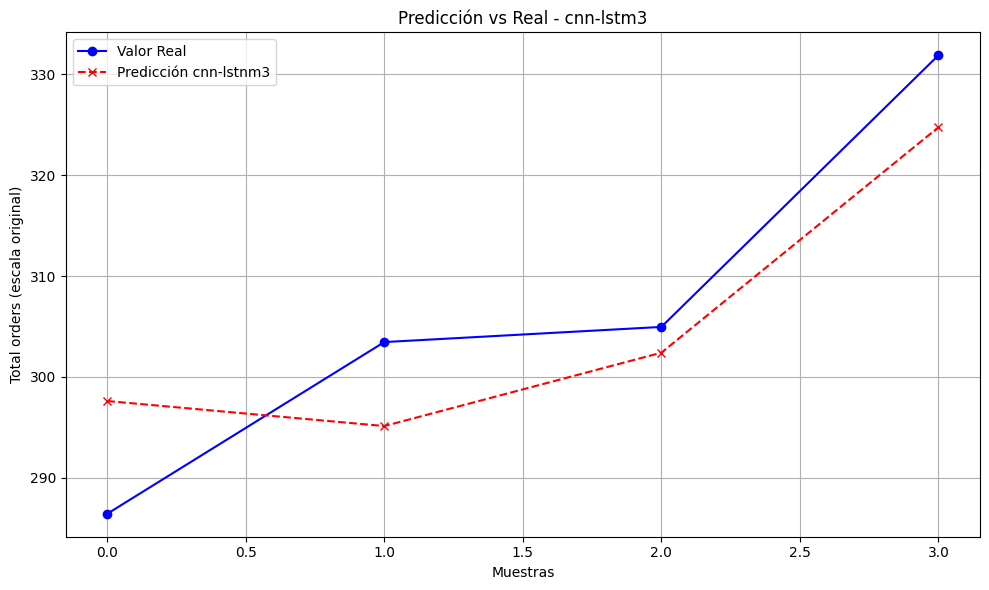

In [322]:

# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Valor Real', color='blue', marker='o')
plt.plot(y_pred, label='Predicción cnn-lstnm3', color='red', linestyle='--', marker='x')
plt.title('Predicción vs Real - cnn-lstm3')
plt.xlabel('Muestras')
plt.ylabel('Total orders (escala original)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

El modelo CNN-LSTM 3 presenta una estructura simplificada en comparación con el modelo anterior. Comienza con una capa Conv1D con 128 filtros y un kernel de tamaño 2, seguida de una capa MaxPooling1D(2) para reducir la dimensionalidad de las características extraídas. Al igual que en modelos previos, se emplea una capa TimeDistributed(Dense()) para procesar cada paso de tiempo en la secuencia de manera independiente, usando activación LeakyReLU para las capas densas.

Una diferencia importante con los modelos anteriores es que la capa LSTM utiliza la activación *'tanh'* en lugar de 'relu'. La función de activación tanh es comúnmente utilizada en redes LSTM ya que ayuda a prevenir problemas de saturación durante el entrenamiento y es más adecuada para capturar dependencias a largo plazo en secuencias.



En cuanto al rendimiento, este modelo tiene un MAE de 7.30 y un RMSE de 7.94, lo que indica que las predicciones son relativamente precisas, aunque todavía lejos de ser perfectas. Comparado con el modelo CNN-LSTM 2, este modelo tiene un rendimiento superior, sugiriendo que la activación tanh en la capa LSTM podría ser más adecuada en este contexto, y que la simplificación de la arquitectura contribuye a una mejor generalización.



### Optuna

In [323]:
def objective(trial):
    # Hiperparámetros a optimizar
    filters = trial.suggest_categorical('filters', [64, 96, 128, 160])
    dense_units = trial.suggest_int('dense_units', 16, 64, step=8)
    lstm_units = trial.suggest_categorical('lstm_units', [32, 48, 64, 80])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-3, log=True)

    # modelo del cnn-lstm1
    model = Sequential([
        Conv1D(filters, 2, activation=LeakyReLU(alpha=0.1), padding='same', input_shape=(n_steps, n_features)),
        MaxPooling1D(2),
        TimeDistributed(Dense(dense_units, activation=LeakyReLU(alpha=0.1))),
        LSTM(lstm_units, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        verbose=0
    )

    # Devolvemos la última MAE de validación
    val_mae = history.history['val_mae'][-1]
    return val_mae


In [324]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Mejores hiperparámetros:", study.best_params)
print("Mejor MAE de validación:", study.best_value)


[I 2025-04-06 14:54:24,192] A new study created in memory with name: no-name-a11cf9ec-a315-4325-980c-430dd4f8ec79
/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-04-06 14:54:27,442] Trial 0 finished with value: 0.09689821302890778 and parameters: {'filters': 160, 'dense_units': 64, 'lstm_units': 48, 'learning_rate': 0.00025912427005532024}. Best is trial 0 with value: 0.09689821302890778.
[I 2025-04-06 14:54:30

Mejores hiperparámetros: {'filters': 96, 'dense_units': 56, 'lstm_units': 80, 'learning_rate': 0.0013075934530649665}
Mejor MAE de validación: 0.0717485249042511


In [327]:
best_params = study.best_params

# modelo con best params
cnnlstm_model_4 = Sequential([
    Conv1D(
        filters=best_params['filters'],
        kernel_size=2,
        activation=LeakyReLU(alpha=0.1),
        padding='same',
        input_shape=(n_steps, n_features)
    ),
    MaxPooling1D(2),
    TimeDistributed(Dense(best_params['dense_units'], activation=LeakyReLU(alpha=0.1))),
    LSTM(best_params['lstm_units'], activation='relu'),
    Dense(1)
], name='CNN_LSTM_Model_3')


cnnlstm_model_4.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss='mse',
    metrics=['mae']
)


history = cnnlstm_model_3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    verbose=1
)




Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.6892e-06 - mae: 0.0014 - val_loss: 0.0153 - val_mae: 0.0920
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.9776e-06 - mae: 0.0016 - val_loss: 0.0153 - val_mae: 0.0918
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.5879e-06 - mae: 0.0014 - val_loss: 0.0153 - val_mae: 0.0918
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.3429e-06 - mae: 0.0014 - val_loss: 0.0153 - val_mae: 0.0917
Epoch 5/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2576e-06 - mae: 0.0014

/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.2547e-06 - mae: 0.0014 - val_loss: 0.0154 - val_mae: 0.0916
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.5137e-06 - mae: 0.0015 - val_loss: 0.0153 - val_mae: 0.0916
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.1159e-06 - mae: 0.0013 - val_loss: 0.0153 - val_mae: 0.0917
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.7942e-06 - mae: 0.0012 - val_loss: 0.0154 - val_mae: 0.0914
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.0924e-06 - mae: 0.0012 - val_loss: 0.0154 - val_mae: 0.0915
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.0412e-06 - mae: 0.0012 - val_loss: 0.0154 - val_mae: 0.0916
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.9553e-06 - mae: 0.0013 - val_loss: 0.0154 - val_mae: 0.0912
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.7871e-06 - mae: 0.0014 - val_loss: 0.0154 - val_mae: 0.0911
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/ste

In [328]:
# Evaluar el modelo
loss, mae = cnnlstm_model_3.evaluate(X_test, y_test, verbose=0)
print(f"MAE (normalizado): {mae:.4f}")

# Predicciones normalizadas
y_pred_norm = cnnlstm_model_3.predict(X_test)

# Desescalar predicciones
y_pred = scaler.inverse_transform(np.hstack([
    np.zeros((y_pred_norm.shape[0], df.shape[1] - 1)), y_pred_norm
]))[:, -1]

# Desescalar valores reales
y_test_original = scaler.inverse_transform(np.hstack([
    np.zeros((y_test.shape[0], df.shape[1] - 1)), y_test.reshape(-1, 1)
]))[:, -1]

# Calcular métricas reales
mae_original = mean_absolute_error(y_test_original, y_pred)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred))

print(f"MAE (original): {mae_original:.2f}")
print(f"RMSE (original): {rmse_original:.2f}")


MAE (normalizado): 0.0176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MAE (original): 8.57
RMSE (original): 9.53


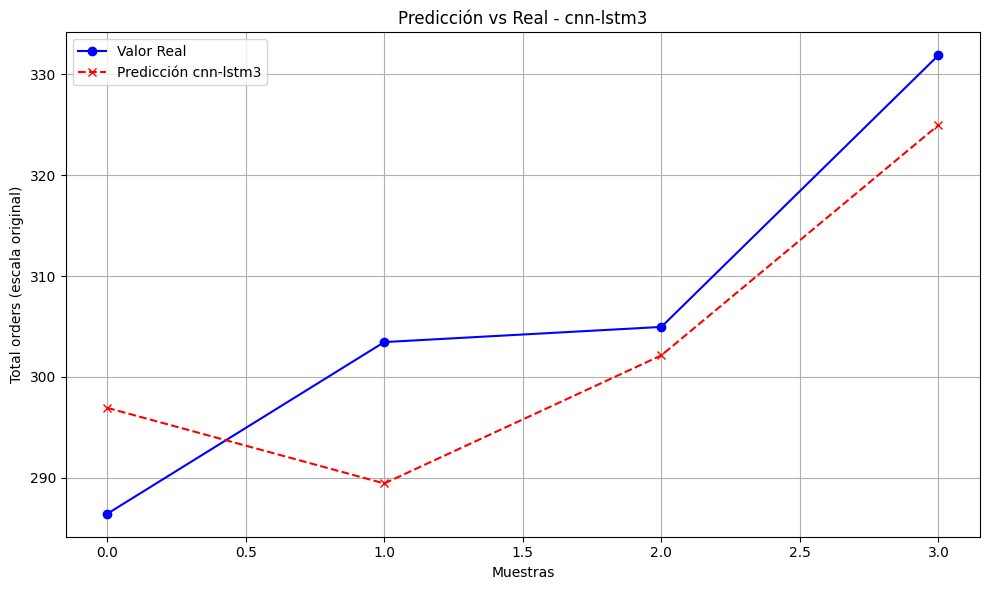

In [329]:

# Gráfica Real vs Predicción
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Valor Real', color='blue', marker='o')
plt.plot(y_pred, label='Predicción cnn-lstm3', color='red', linestyle='--', marker='x')
plt.title('Predicción vs Real - cnn-lstm3')
plt.xlabel('Muestras')
plt.ylabel('Total orders (escala original)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Estos resultados indican que el modelo es relativamente preciso, pero todavía podría beneficiarse de ajustes adicionales. El objetivo principal en este caso es optimizar los hiperparámetros para mejorar la capacidad predictiva del modelo. Los valores de MAE y RMSE muestran que el modelo aún tiene margen para mejorar, por lo que es recomendable explorar más combinaciones de hiperparámetros y probar con un mayor número de épocas para evaluar si el modelo mejora con más entrenamiento.

### Conclusiones

En conclusión, después de evaluar varios modelos, el mejor modelo fue el CNN-LSTM_Model_1, el cual alcanzó un MAE de 5.79 y un RMSE de 7.06. Este modelo combinó eficientemente capas convolucionales y LSTM, lo que permitió capturar tanto características locales como dependencias temporales en los datos de secuencia. A pesar de que otros modelos, como los modelos LSTM y los modelos CNN-LSTM con diferentes configuraciones de hiperparámetros, también mostraron resultados competitivos, el CNN-LSTM_Model_1 logró el mejor rendimiento en términos de error absoluto medio (MAE) y raíz del error cuadrático medio (RMSE), lo que lo convierte en el modelo más efectivo para esta tarea en particular.